- __Nombre:__ Jan Polanco Velasco
- __Tipo de Problema:__ Modelo Clasificación binaria supervisada
- __Variables objetivo:__ 'LOAN', 'HOUSING'


# Libraries

```
conda create –n pycaret2023 python=3.8
conda activate pycaret2023
pip install pycaret==3.0.0rc9
pip install seaborn==0.12.2
pip install catboost==1.1.1
pip install xgboost==1.7.4
pip install ydata-profiling==4.0.0
pip install optuna==3.1.0
pip install contextily==1.3.0
```


In [1]:
import numpy as np
import pandas as pd
import pathlib as pl
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patheffects import withStroke
from scipy import stats
import itertools
from pycaret.classification import * 
from pycaret.classification import ClassificationExperiment

# Read Data

In [3]:
current_path    = pl.Path.cwd()
file_path       = current_path.joinpath('base_prueba.csv')
df              = pd.read_csv(file_path, sep=',')
df.head()

Unnamed: 0  age     job   marital  education  default      balance  \
0         255   26  admin.   married  secondary        0   808.730361   
1        3124   28  admin.    single    unknown        0          NaN   
2        5990   48  admin.    single  secondary        0   467.195779   
3        6066   31  admin.    single    unknown        0  -261.672516   
4        7170   32  admin.  divorced  secondary        0  1695.013083   

   housing  loan   contact  ...     ingresos      egresos  saldo_captacion  \
0        1     1   unknown  ...  3280.360862  3051.831513     12661.246820   
1        1     1  cellular  ...  3439.248846  3065.786619      9843.672164   
2        1     1   unknown  ...  2572.843554  2462.805226     15617.888920   
3        1     1   unknown  ...   661.940113          NaN     14006.456990   
4        1     1   unknown  ...          NaN  5692.352045     12722.502990   

      saldo_tdc monto_trx_tdc  cantidad_trx_tdc      saldo_lb     saldo_veh  \
0   6965.430755   1108.591174         21.683800  42981.114440  105481.67020   
1  10103.275870   -722.150618               NaN  55386.819020  108854.72940   
2  13255.033570   2742.755771         27.275966   -333.018237   50972.31829   
3   8656.416179   2030.049344         12.986956  25406.939810   49246.47807   
4  12708.623910   1188.717769         17.700467  40470.480510   55172.01019   

   monto_trx_debito  cantidad_trx_debito  
0       6248.690727            24.886023  
1      -1603.077394            29.637257  
2      -1120.281419            47.370673  
3       2355.165592                  NaN  
4       5267.538885           -12.190038  

[5 rows x 32 columns]

In [4]:
columns_to_move = ['BALANCE', 'DURATION', 'CAMPAIGN', 'PDAYS', 'PREVIOUS', 'LOAN', 'HOUSING']
df = df.rename(columns={'Unnamed: 0': 'id'}).sort_values('id').reset_index(drop=True)
df.columns = df.columns.str.upper()
df = df[[col for col in df.columns if col not in columns_to_move]+columns_to_move]
print('El dataset tiene un tamaño de: ',df.shape)
df.head()

El dataset tiene un tamaño de:  (11162, 32)


ID  AGE         JOB  MARITAL  EDUCATION  DEFAULT  CONTACT POUTCOME  \
0   0   59      admin.  married  secondary        0  unknown  unknown   
1   1   56      admin.  married  secondary        0  unknown  unknown   
2   2   41  technician  married  secondary        0  unknown  unknown   
3   3   55    services  unknown  secondary        0  unknown  unknown   
4   4   54      admin.  married   tertiary        0  unknown  unknown   

   DEPOSIT  TENENCIA_AHORROS  ...    SALDO_VEH  MONTO_TRX_DEBITO  \
0        1               1.0  ...  40855.61994       4004.988678   
1        1               1.0  ...          NaN       7126.370878   
2        1               NaN  ...          NaN               NaN   
3        1               NaN  ...          NaN       5466.849819   
4        1               0.0  ...          NaN               NaN   

   CANTIDAD_TRX_DEBITO      BALANCE     DURATION  CAMPAIGN  PDAYS  PREVIOUS  \
0            26.806785  2408.074830  1048.258040         1     -1         0   
1                  NaN   156.895563  1498.990449         1     -1         0   
2                  NaN  1341.804596  1395.696165         1     -1         0   
3             9.389375          NaN   590.390896         1     -1         0   
4                  NaN   239.168049   709.270562         2     -1         0   

   LOAN  HOUSING  
0     0        1  
1     0        0  
2     0        1  
3     0        1  
4     0        0  

[5 rows x 32 columns]

In [5]:
df.dtypes

ID                       int64
AGE                      int64
JOB                     object
MARITAL                 object
EDUCATION               object
DEFAULT                  int64
CONTACT                 object
POUTCOME                object
DEPOSIT                  int64
TENENCIA_AHORROS       float64
TENENCIA_CORRIENTE     float64
TENENCIA_CDT           float64
TENENCIA_TDC           float64
TENENCIA_LB            float64
TENENCIA_VEHICULO      float64
INGRESOS               float64
EGRESOS                float64
SALDO_CAPTACION        float64
SALDO_TDC              float64
MONTO_TRX_TDC          float64
CANTIDAD_TRX_TDC       float64
SALDO_LB               float64
SALDO_VEH              float64
MONTO_TRX_DEBITO       float64
CANTIDAD_TRX_DEBITO    float64
BALANCE                float64
DURATION               float64
CAMPAIGN                 int64
PDAYS                    int64
PREVIOUS                 int64
LOAN                     int64
HOUSING                  int64
dtype: o

# Summary - Describe

In [10]:
list_columns= df.columns.tolist()
df[list_columns[1:]].describe(include='all').round(3)

AGE         JOB  MARITAL  EDUCATION    DEFAULT   CONTACT  \
count   11162.000       11162    11162      11162  11162.000     11162   
unique        NaN          12        4          4        NaN         3   
top           NaN  management  married  secondary        NaN  cellular   
freq          NaN        2566     5038       4378        NaN      8042   
mean       41.232         NaN      NaN        NaN      0.015       NaN   
std        11.913         NaN      NaN        NaN      0.122       NaN   
min        18.000         NaN      NaN        NaN      0.000       NaN   
25%        32.000         NaN      NaN        NaN      0.000       NaN   
50%        39.000         NaN      NaN        NaN      0.000       NaN   
75%        49.000         NaN      NaN        NaN      0.000       NaN   
max        95.000         NaN      NaN        NaN      1.000       NaN   

       POUTCOME    DEPOSIT  TENENCIA_AHORROS  TENENCIA_CORRIENTE  ...  \
count     11162  11162.000         10612.000           10601.000  ...   
unique        4        NaN               NaN                 NaN  ...   
top     unknown        NaN               NaN                 NaN  ...   
freq       8326        NaN               NaN                 NaN  ...   
mean        NaN      0.474             0.696               0.102  ...   
std         NaN      0.499             0.460               0.303  ...   
min         NaN      0.000             0.000               0.000  ...   
25%         NaN      0.000             0.000               0.000  ...   
50%         NaN      0.000             1.000               0.000  ...   
75%         NaN      1.000             1.000               0.000  ...   
max         NaN      1.000             1.000               1.000  ...   

         SALDO_VEH  MONTO_TRX_DEBITO  CANTIDAD_TRX_DEBITO    BALANCE  \
count     2238.000          7279.000             7275.000   8884.000   
unique         NaN               NaN                  NaN        NaN   
top            NaN               NaN                  NaN        NaN   
freq           NaN               NaN                  NaN        NaN   
mean     60792.064          3009.644               20.132   1585.879   
std      28029.766          1997.272               14.974   3313.186   
min     -28294.009         -3589.717              -34.847  -6805.221   
25%      42240.957          1662.964               10.017    172.322   
50%      60876.765          3034.719               20.259    604.052   
75%      80033.607          4322.364               30.332   1772.260   
max     170840.876         11053.698               82.522  81269.474   

         DURATION   CAMPAIGN      PDAYS   PREVIOUS       LOAN    HOUSING  
count   11162.000  11162.000  11162.000  11162.000  11162.000  11162.000  
unique        NaN        NaN        NaN        NaN        NaN        NaN  
top           NaN        NaN        NaN        NaN        NaN        NaN  
freq          NaN        NaN        NaN        NaN        NaN        NaN  
mean      401.982      2.508     51.330      0.833      0.131      0.473  
std       347.281      2.722    108.758      2.292      0.337      0.499  
min        -1.354      1.000     -1.000      0.000      0.000      0.000  
25%       168.977      1.000     -1.000      0.000      0.000      0.000  
50%       286.480      2.000     -1.000      0.000      0.000      0.000  
75%       526.383      3.000     20.750      1.000      0.000      1.000  
max      3892.989     63.000    854.000     58.000      1.000      1.000  

[11 rows x 31 columns]

Antes de empezar cualquier tratamiento del dataset, es importante conocerlo. Para ello, se puede utilizar la función describe() que realiza un EDA(Exploratory Data Analysis) que nos proporciona un resumen estadístico de las variables. En el dataframe, las variables numéricas son: 'AGE', INGRESOS', 'EGRESOS', 'SALDO_CAPTACION', 'SALDO_TDC', 'MONTO_TRX_TDC', 'CANTIDAD_TRX_TDC', 'SALDO_LB', 'SALDO_VEH', 'MONTO_TRX_DEBITO', 'CANTIDAD_TRX_DEBITO','BALANCE'. 

Las variables categoricas son: 'JOB', 'MARITAL', 'EDUCATION', 'DEFAULT','CONTACT', 'POUTCOME', 'DEPOSIT', 'TENENCIA_AHORROS', 'TENENCIA_CORRIENTE','TENENCIA_CDT', 'TENENCIA_TDC', 'TENENCIA_LB', 'TENENCIA_VEHICULO', 'DURATION', 'CAMPAIGN', 'PDAYS',  'PREVIOUS'.

El indice es 'ID'.

Las variables predictoras son: 'LOAN', 'HOUSING'.

En la mayoria de las variables se tienen valores NaN (Not A Number) en el caso de las variables categoricas nominales los NaN se considera como valores 'unknown'. En el caso de las variables categoricas ordinales los valores NaN se considera como valores 0 con la funcion fillna(), es decir no cumplen con la condicion binaria de la variable.

En el caso de las variables numericas se reemplazan los valores NaN por 0, se descarta otra tecnica de imputacion de datos como la media de la variable, etc.

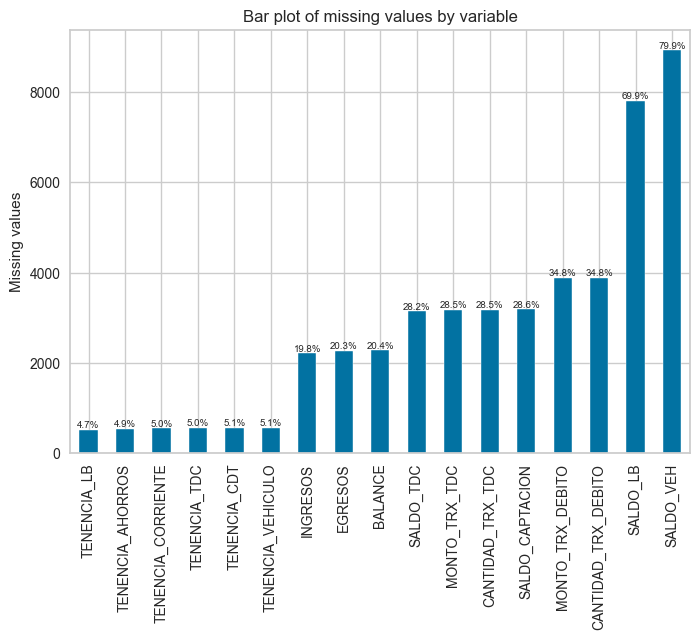

In [6]:
sns.set_style("whitegrid")

missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]
missing_values.sort_values(ascending=True, inplace=True)

total_values = len(df)
percent_missing = (missing_values / total_values) * 100


ax = missing_values.plot(kind='bar')

for i, v in enumerate(missing_values):
    ax.text(i, v + 0.5, f"{percent_missing.iloc[i]:.1f}%", ha='center', va='bottom', fontsize=7)

plt.ylabel('Missing values')
plt.title('Bar plot of missing values by variable')
plt.show()

Variables como 'SALDO_VEH' tienen el 79.9% de los datos nulos, seguidos por 'SALDO_LB' con 69.9%, etc. 

In [7]:
df.columns[15:-2]

Index(['INGRESOS', 'EGRESOS', 'SALDO_CAPTACION', 'SALDO_TDC', 'MONTO_TRX_TDC',
       'CANTIDAD_TRX_TDC', 'SALDO_LB', 'SALDO_VEH', 'MONTO_TRX_DEBITO',
       'CANTIDAD_TRX_DEBITO', 'BALANCE', 'DURATION', 'CAMPAIGN', 'PDAYS',
       'PREVIOUS'],
      dtype='object')

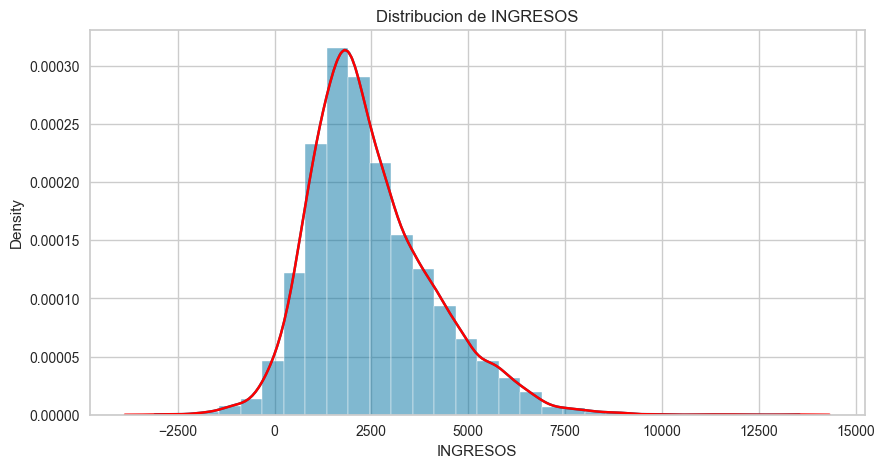

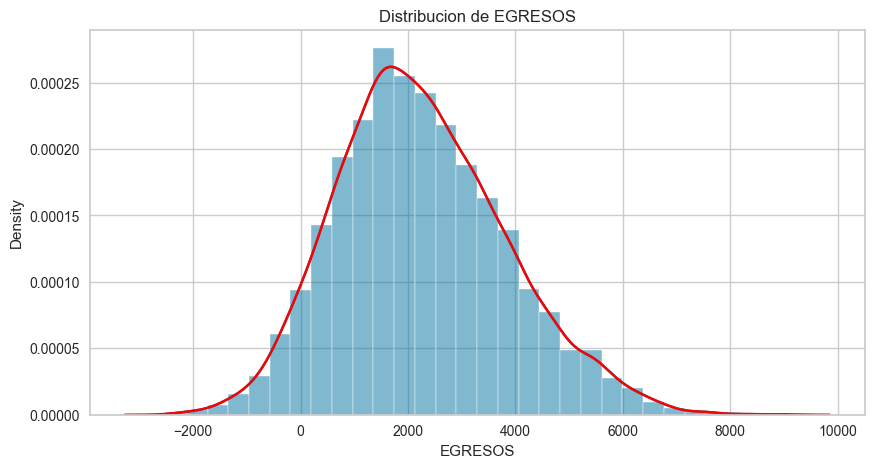

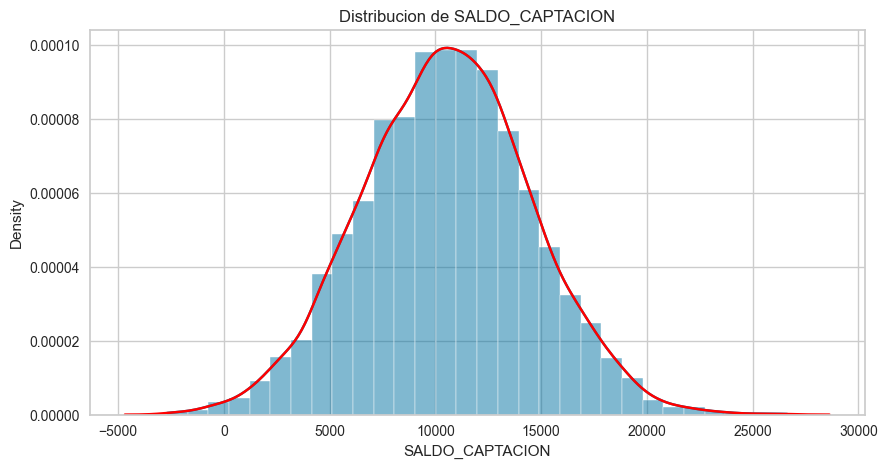

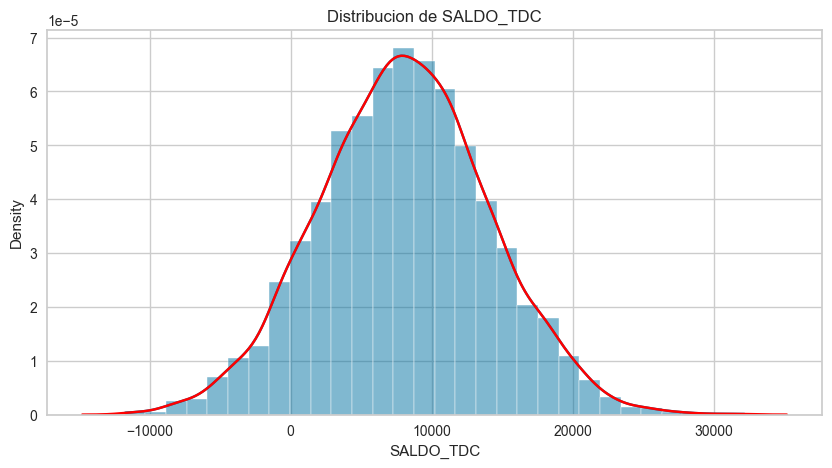

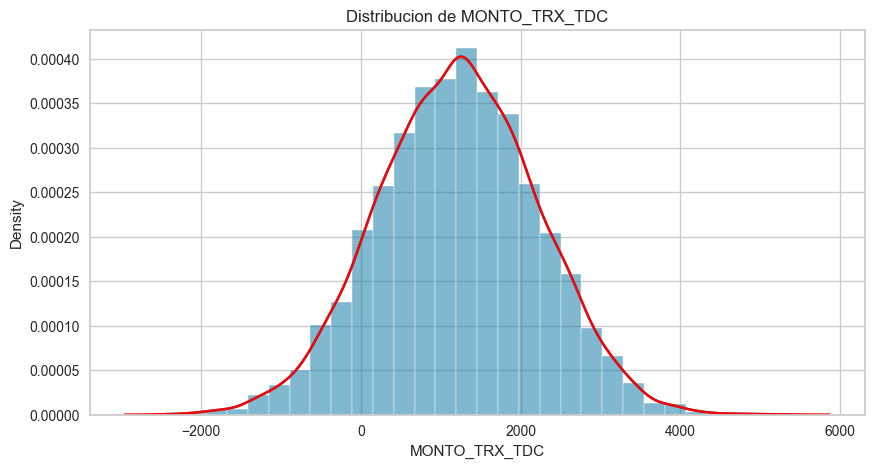

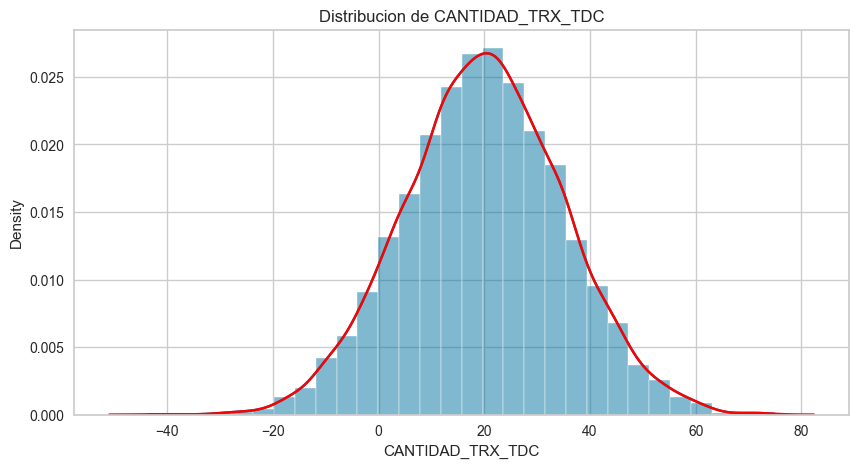

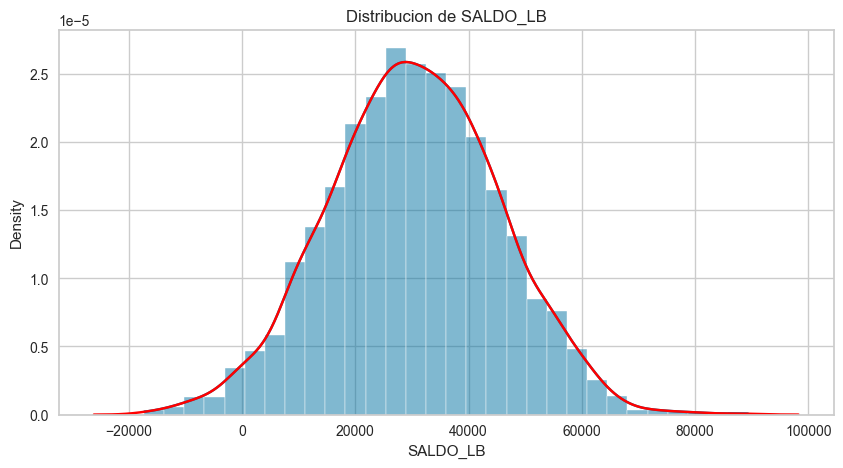

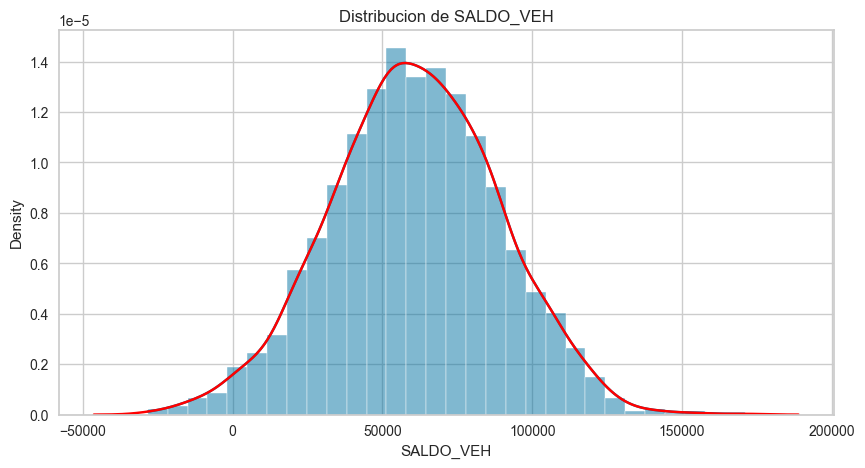

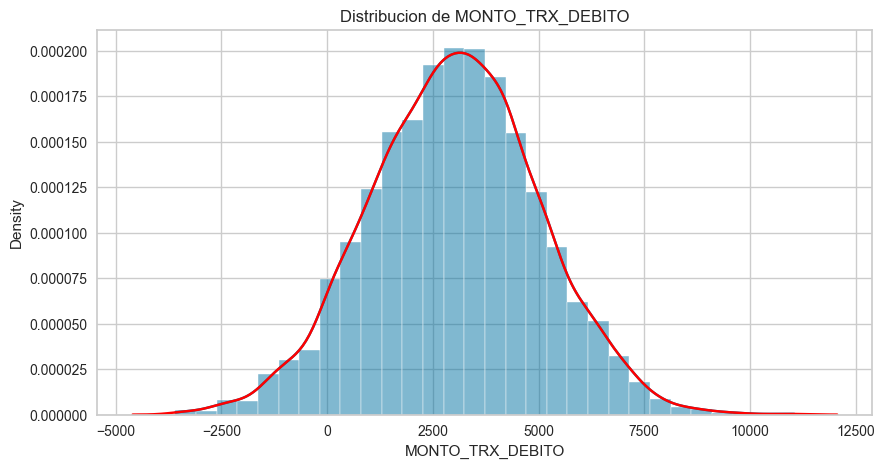

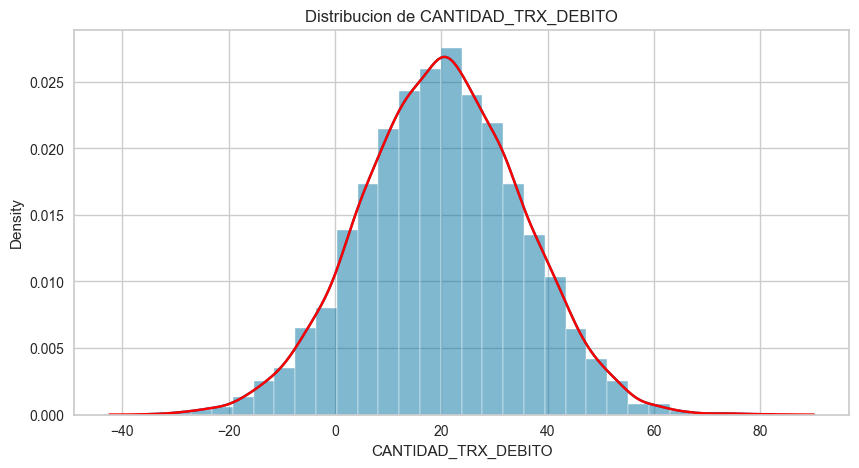

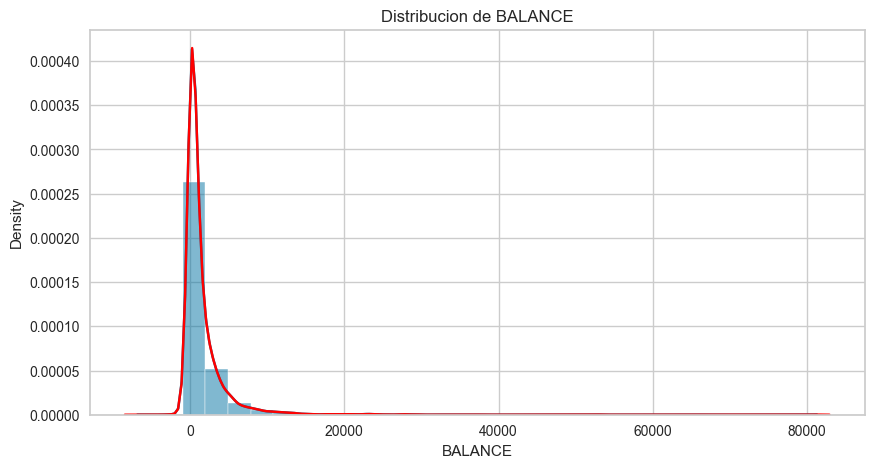

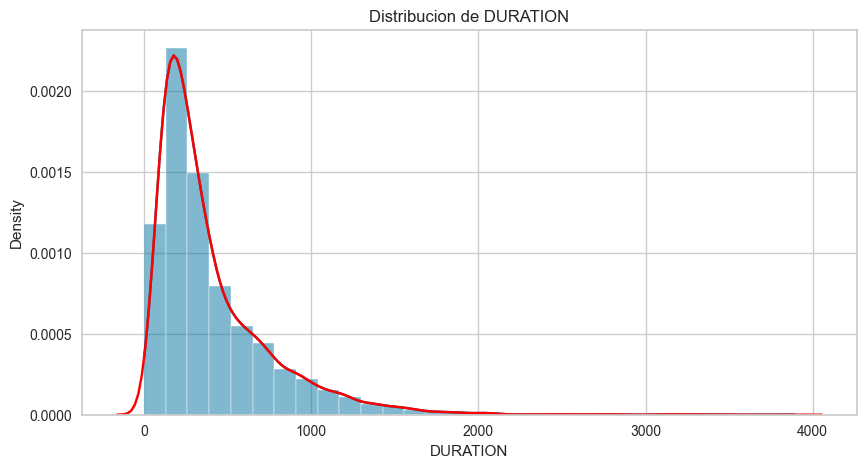

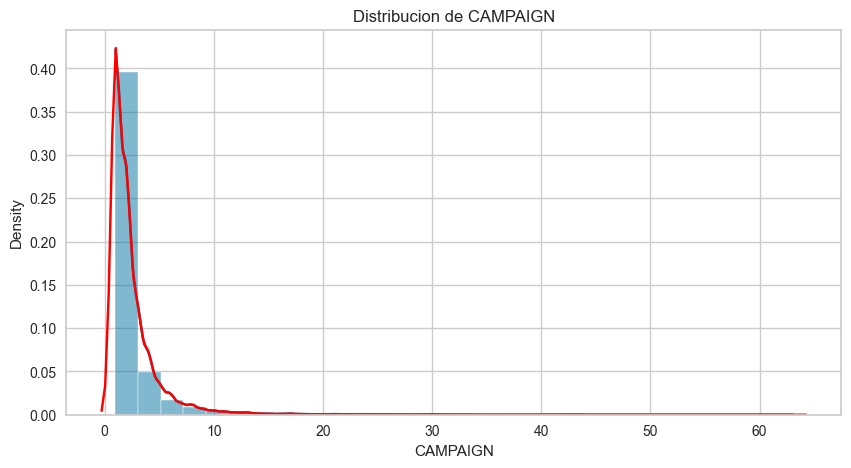

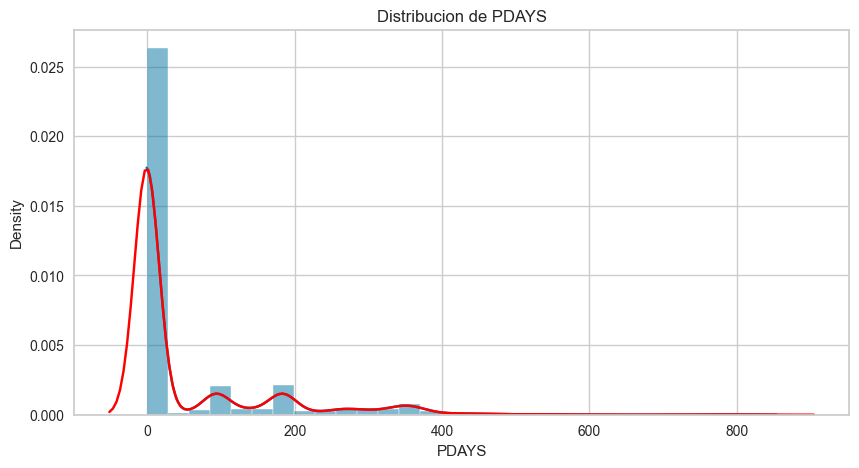

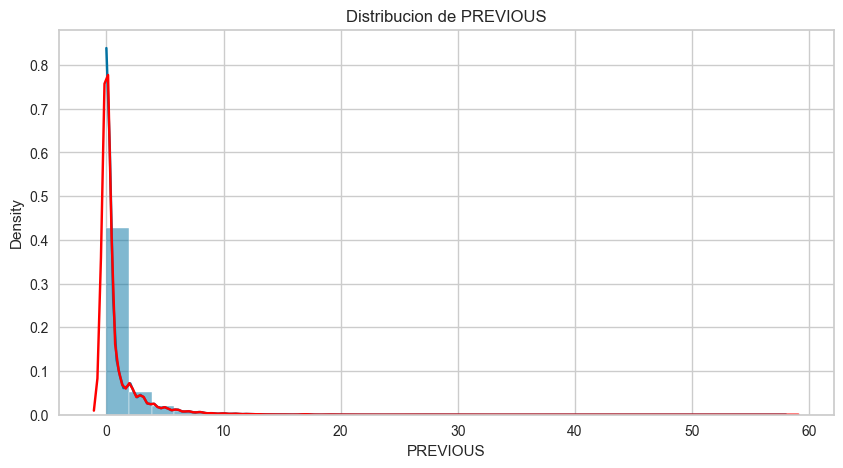

In [8]:
for col in df.columns[15:-2]:
    plt.figure(figsize=(10, 5))
    plt.title(f'Distribucion de {col}')
    sns.histplot(df[col], bins=30, kde=True, stat='density')
    sns.kdeplot(df[col], color='red')
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.savefig(f'density_{col}_plot.png')
    plt.show()

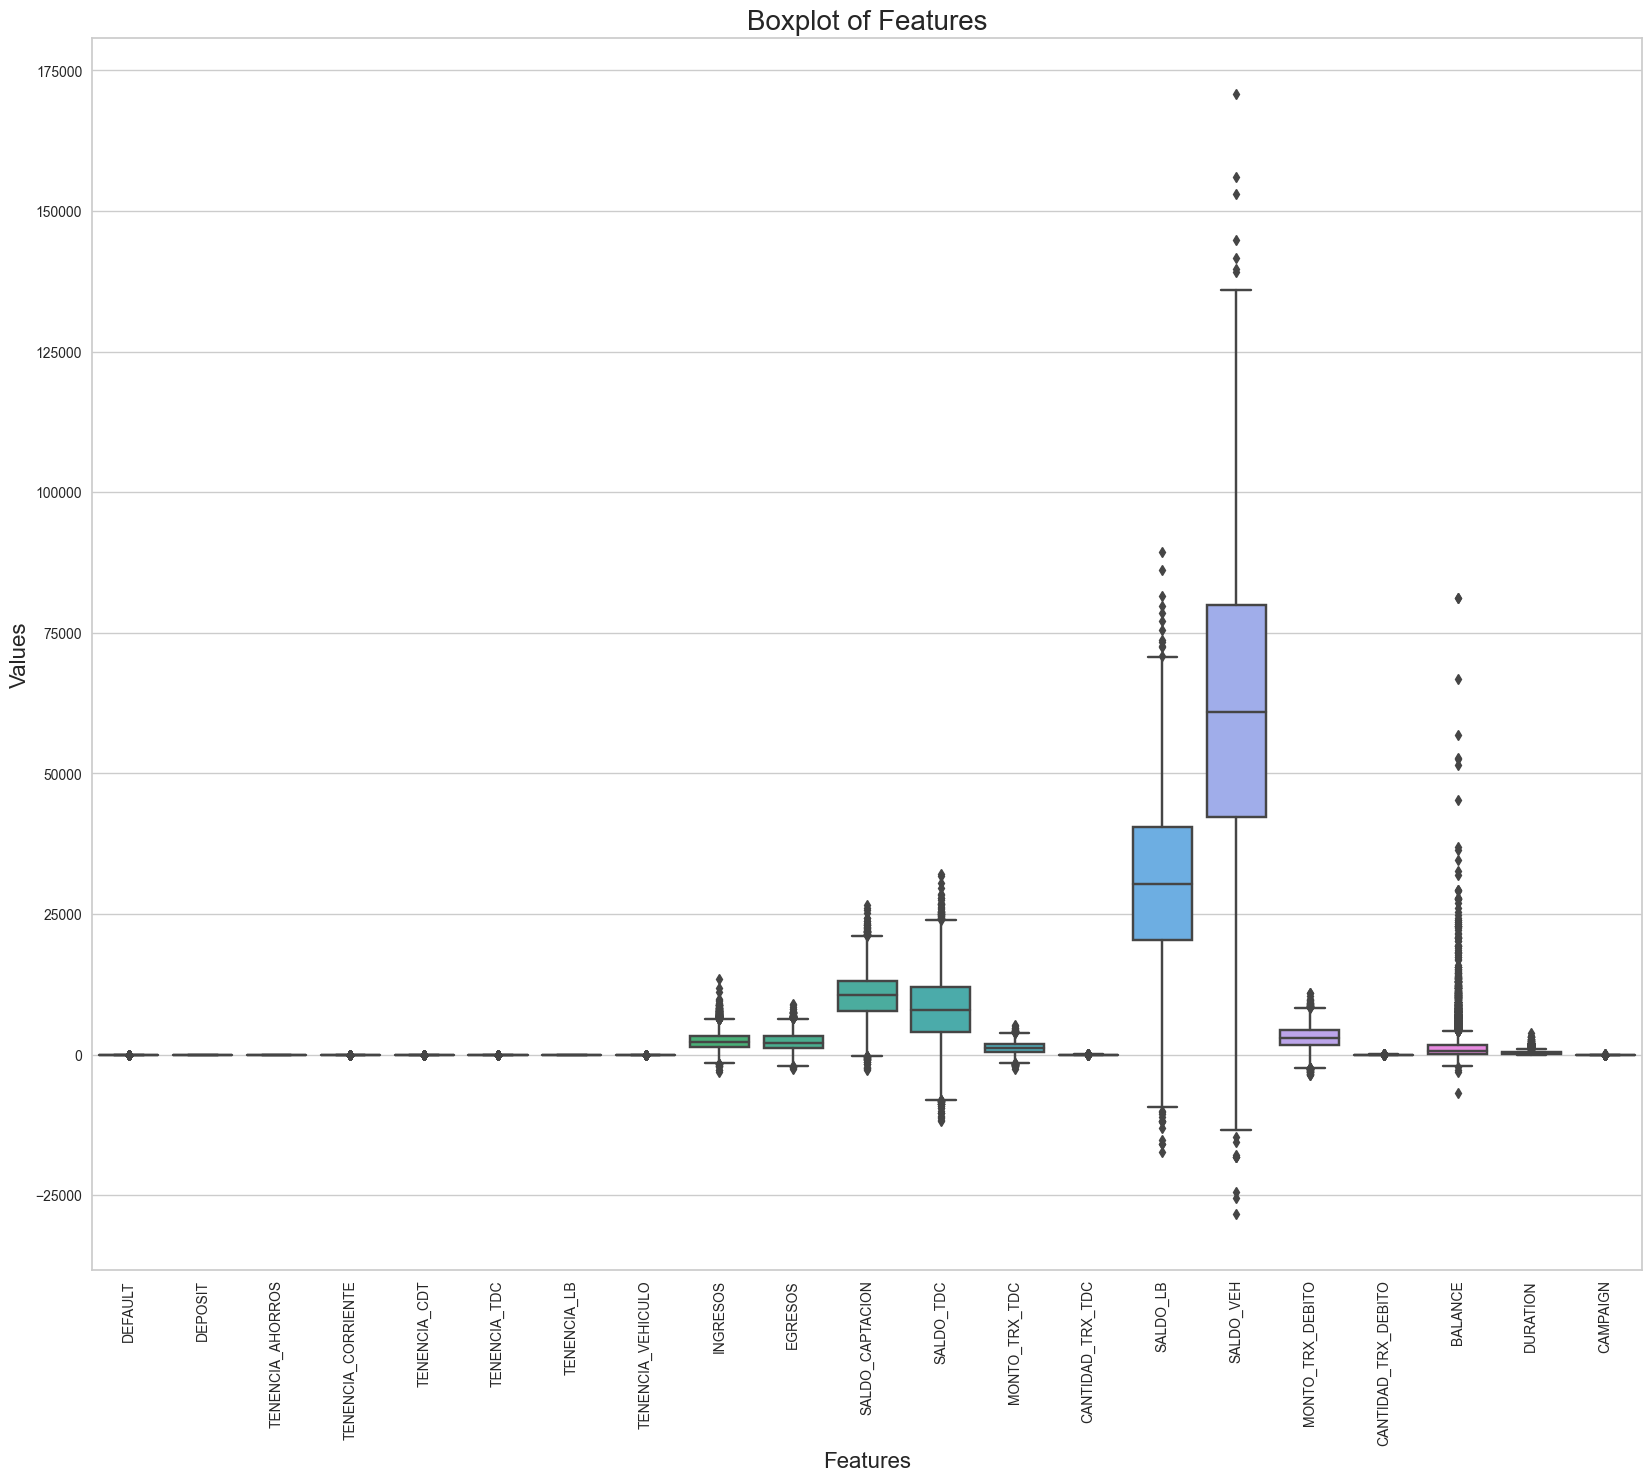

In [11]:
fig, ax = plt.subplots(figsize=(20, 16))
sns.boxplot(data=df[list_columns[2:-4]], ax=ax)

ax.set_title('Boxplot of Features', fontsize=20)
ax.set_xlabel('Features', fontsize=16)
ax.set_ylabel('Values', fontsize=16)

plt.xticks(rotation=90)

plt.show()

# Variables categóricas

In [12]:
def map_categorical_variables(df,list_variables):
    """
    Mapea variables categóricas en un DataFrame utilizando un diccionario de mapeo.

    Parameters:
        df (pd.DataFrame): El DataFrame que contiene las variables categóricas a mapear.

    Returns:
        pd.DataFrame: El DataFrame con las variables categóricas mapeadas y los valores nulos rellenados con 0.
    """

    for col in list_variables:
        value_counts = df[col].value_counts()
        mapping_dict = {value: i for i, value in enumerate(value_counts.index)}
        print('---------------------------------------------------')
        print('La variable ', col, ' tiene este diccionario:\n')
        print(mapping_dict)
        df[col] = df[col].map(mapping_dict)
        df[col] = df[col].fillna(0).astype(object)

        df[col].value_counts().plot(kind='bar', title=col)

    return df

In [13]:
df.columns

Index(['ID', 'AGE', 'JOB', 'MARITAL', 'EDUCATION', 'DEFAULT', 'CONTACT',
       'POUTCOME', 'DEPOSIT', 'TENENCIA_AHORROS', 'TENENCIA_CORRIENTE',
       'TENENCIA_CDT', 'TENENCIA_TDC', 'TENENCIA_LB', 'TENENCIA_VEHICULO',
       'INGRESOS', 'EGRESOS', 'SALDO_CAPTACION', 'SALDO_TDC', 'MONTO_TRX_TDC',
       'CANTIDAD_TRX_TDC', 'SALDO_LB', 'SALDO_VEH', 'MONTO_TRX_DEBITO',
       'CANTIDAD_TRX_DEBITO', 'BALANCE', 'DURATION', 'CAMPAIGN', 'PDAYS',
       'PREVIOUS', 'LOAN', 'HOUSING'],
      dtype='object')

In [14]:
df2 = df.copy()
df2 = pd.get_dummies(df2, columns=['LOAN', 'HOUSING'])
df2.head()

ID  AGE         JOB  MARITAL  EDUCATION  DEFAULT  CONTACT POUTCOME  \
0   0   59      admin.  married  secondary        0  unknown  unknown   
1   1   56      admin.  married  secondary        0  unknown  unknown   
2   2   41  technician  married  secondary        0  unknown  unknown   
3   3   55    services  unknown  secondary        0  unknown  unknown   
4   4   54      admin.  married   tertiary        0  unknown  unknown   

   DEPOSIT  TENENCIA_AHORROS  ...  CANTIDAD_TRX_DEBITO      BALANCE  \
0        1               1.0  ...            26.806785  2408.074830   
1        1               1.0  ...                  NaN   156.895563   
2        1               NaN  ...                  NaN  1341.804596   
3        1               NaN  ...             9.389375          NaN   
4        1               0.0  ...                  NaN   239.168049   

      DURATION  CAMPAIGN  PDAYS  PREVIOUS  LOAN_0  LOAN_1  HOUSING_0  \
0  1048.258040         1     -1         0    True   False      False   
1  1498.990449         1     -1         0    True   False       True   
2  1395.696165         1     -1         0    True   False      False   
3   590.390896         1     -1         0    True   False      False   
4   709.270562         2     -1         0    True   False       True   

   HOUSING_1  
0       True  
1      False  
2       True  
3       True  
4      False  

[5 rows x 34 columns]

# Checkpoint 1

In [15]:
df1 = df.copy()

# Variables Categoricas nominales

---------------------------------------------------
La variable  JOB  tiene este diccionario:

{'management': 0, 'blue-collar': 1, 'technician': 2, 'admin.': 3, 'services': 4, 'retired': 5, 'self-employed': 6, 'student': 7, 'unemployed': 8, 'entrepreneur': 9, 'housemaid': 10, 'unknown': 11}
---------------------------------------------------
La variable  MARITAL  tiene este diccionario:

{'married': 0, 'single': 1, 'unknown': 2, 'divorced': 3}
---------------------------------------------------
La variable  EDUCATION  tiene este diccionario:

{'secondary': 0, 'tertiary': 1, 'unknown': 2, 'primary': 3}
---------------------------------------------------
La variable  CONTACT  tiene este diccionario:

{'cellular': 0, 'unknown': 1, 'telephone': 2}
---------------------------------------------------
La variable  POUTCOME  tiene este diccionario:

{'unknown': 0, 'failure': 1, 'success': 2, 'other': 3}
---------------------------------------------------
La variable  DEFAULT  tiene este diccio

ID  AGE JOB MARITAL EDUCATION DEFAULT CONTACT POUTCOME DEPOSIT  \
0   0   59   3       0         0       0       1        0       1   
1   1   56   3       0         0       0       1        0       1   
2   2   41   2       0         0       0       1        0       1   
3   3   55   4       2         0       0       1        0       1   
4   4   54   3       0         1       0       1        0       1   

  TENENCIA_AHORROS  ...    SALDO_VEH MONTO_TRX_DEBITO CANTIDAD_TRX_DEBITO  \
0              0.0  ...  40855.61994      4004.988678           26.806785   
1              0.0  ...          NaN      7126.370878                 NaN   
2              0.0  ...          NaN              NaN                 NaN   
3              0.0  ...          NaN      5466.849819            9.389375   
4              1.0  ...          NaN              NaN                 NaN   

       BALANCE     DURATION  CAMPAIGN  PDAYS  PREVIOUS  LOAN  HOUSING  
0  2408.074830  1048.258040         1     -1         0     0        1  
1   156.895563  1498.990449         1     -1         0     0        0  
2  1341.804596  1395.696165         1     -1         0     0        1  
3          NaN   590.390896         1     -1         0     0        1  
4   239.168049   709.270562         2     -1         0     0        0  

[5 rows x 32 columns]

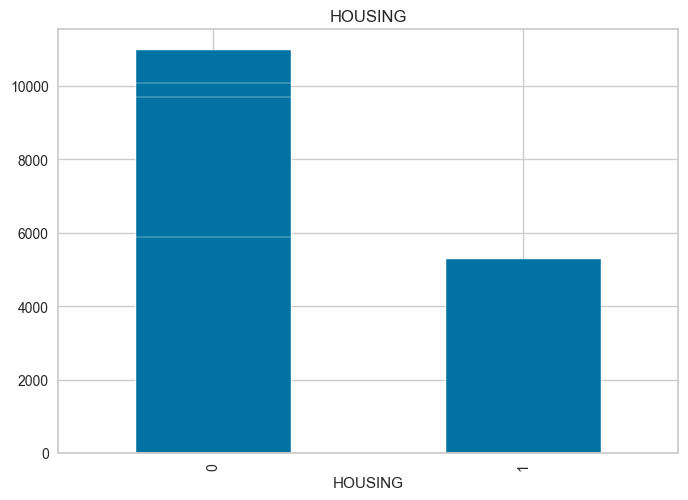

In [16]:
var_cat_nom     = ['JOB', 'MARITAL', 'EDUCATION','CONTACT','POUTCOME']
var_cat_ord     = ['DEFAULT','DEPOSIT', 'TENENCIA_AHORROS', 'TENENCIA_CORRIENTE','TENENCIA_CDT', 'TENENCIA_TDC', 'TENENCIA_LB', 'TENENCIA_VEHICULO']

list_columns    = df1.columns.tolist()
var_categoricas = var_cat_nom + var_cat_ord + ['LOAN', 'HOUSING']

df1             = map_categorical_variables(df1,var_categoricas)
df1.head()

In [17]:
for var in var_categoricas:
    print('---------------------------------------------------')
    print('La variable ', var, ' tiene estos valores:\n')
    print(df1[var].value_counts())

---------------------------------------------------
La variable  JOB  tiene estos valores:

JOB
0     2566
1     1944
2     1823
3     1334
4      923
5      778
6      405
7      360
8      357
9      328
10     274
11      70
Name: count, dtype: int64
---------------------------------------------------
La variable  MARITAL  tiene estos valores:

MARITAL
0    5038
1    2790
2    2295
3    1039
Name: count, dtype: int64
---------------------------------------------------
La variable  EDUCATION  tiene estos valores:

EDUCATION
0    4378
1    2962
2    2625
3    1197
Name: count, dtype: int64
---------------------------------------------------
La variable  CONTACT  tiene estos valores:

CONTACT
0    8042
1    2346
2     774
Name: count, dtype: int64
---------------------------------------------------
La variable  POUTCOME  tiene estos valores:

POUTCOME
0    8326
1    1228
2    1071
3     537
Name: count, dtype: int64
---------------------------------------------------
La variable  DEFAU

# Variables Categoricas Nominales


- __JOB__  tiene este diccionario:
    - 'management': 0
    - 'blue-collar': 1
    - 'technician': 2
    - 'admin.': 3
    - 'services': 4,
    - 'retired': 5
    - 'self-employed': 6
    - 'student': 7
    - 'unemployed': 8
    - 'entrepreneur': 9
    - 'housemaid': 10
    - 'unknown': 11

- __MARITAL__  tiene este diccionario:
    - 'married': 0
    - 'single': 1
    - 'unknown': 2
    - 'divorced': 3

- __EDUCATION__  tiene este diccionario:
    - 'secondary': 0
    - 'tertiary': 1
    - 'unknown': 2
    - 'primary': 3

- __CONTACT__  tiene este diccionario:
    - 'cellular': 0
    - 'unknown': 1
    - 'telephone': 2

- __POUTCOME__  tiene este diccionario:
    - 'unknown': 0
    - 'failure': 1
    - 'success': 2
    - 'other': 3

# Variables Categoricas Ordinales

- DEFAULT tiene este diccionario:
    - 0: 0
    - 1: 1

- DEPOSIT tiene este diccionario:
    - 0: 0
    - 1: 1

- TENENCIA_AHORROS tiene este diccionario:
    - 1: 0
    - 0: 1

- TENENCIA_CORRIENTE tiene este diccionario:
    - 0: 0
    - 1: 1

- TENENCIA_CDT tiene este diccionario:
    - 0: 0
    - 1: 1

- TENENCIA_TDC tiene este diccionario:
    - 1: 0
    - 0: 1

- TENENCIA_LB tiene este diccionario:
    - 0: 0
    - 1: 1

- TENENCIA_VEHICULO tiene este diccionario:
    - 0: 0
    - 1: 1

In [18]:
df1.dtypes

ID                       int64
AGE                      int64
JOB                     object
MARITAL                 object
EDUCATION               object
DEFAULT                 object
CONTACT                 object
POUTCOME                object
DEPOSIT                 object
TENENCIA_AHORROS        object
TENENCIA_CORRIENTE      object
TENENCIA_CDT            object
TENENCIA_TDC            object
TENENCIA_LB             object
TENENCIA_VEHICULO       object
INGRESOS               float64
EGRESOS                float64
SALDO_CAPTACION        float64
SALDO_TDC              float64
MONTO_TRX_TDC          float64
CANTIDAD_TRX_TDC       float64
SALDO_LB               float64
SALDO_VEH              float64
MONTO_TRX_DEBITO       float64
CANTIDAD_TRX_DEBITO    float64
BALANCE                float64
DURATION               float64
CAMPAIGN                 int64
PDAYS                    int64
PREVIOUS                 int64
LOAN                    object
HOUSING                 object
dtype: o

# Variables Numéricas

Como las variables numericas siguen una distribucion normal de acuerdo a las imagenes, entonces hacemos una imputacion de los datos NaN con la media de la variable.

In [19]:
def numerical_features(df,list_variables):
    """
    Rellena los valores faltantes en las variables numéricas de un DataFrame con la media de cada columna.

    Parámetros:
        df (pd.DataFrame): El DataFrame que contiene las variables numéricas con valores faltantes a rellenar.
        list_variables (list): Lista de nombres de las columnas que son variables numéricas.

    Retorna:
        pd.DataFrame: El DataFrame con los valores faltantes en las variables numéricas reemplazados por la media de cada columna.
    """
    for col in list_variables:
        df[col] = df[col].fillna(df[col].mean())
    return df

In [20]:
for col in var_categoricas:
    if col in list_columns:
        list_columns.remove(col)

In [21]:
df1 = numerical_features(df1,list_columns[1:])

In [22]:
df1.dtypes

ID                       int64
AGE                      int64
JOB                     object
MARITAL                 object
EDUCATION               object
DEFAULT                 object
CONTACT                 object
POUTCOME                object
DEPOSIT                 object
TENENCIA_AHORROS        object
TENENCIA_CORRIENTE      object
TENENCIA_CDT            object
TENENCIA_TDC            object
TENENCIA_LB             object
TENENCIA_VEHICULO       object
INGRESOS               float64
EGRESOS                float64
SALDO_CAPTACION        float64
SALDO_TDC              float64
MONTO_TRX_TDC          float64
CANTIDAD_TRX_TDC       float64
SALDO_LB               float64
SALDO_VEH              float64
MONTO_TRX_DEBITO       float64
CANTIDAD_TRX_DEBITO    float64
BALANCE                float64
DURATION               float64
CAMPAIGN                 int64
PDAYS                    int64
PREVIOUS                 int64
LOAN                    object
HOUSING                 object
dtype: o

In [23]:
df1[list_columns[1:]].describe(include='all').round(3)

AGE   INGRESOS    EGRESOS  SALDO_CAPTACION  SALDO_TDC  \
count  11162.000  11162.000  11162.000        11162.000  11162.000   
mean      41.232   2480.928   2254.692        10530.469   8035.748   
std       11.913   1422.745   1406.066         3386.398   5112.522   
min       18.000  -3090.885  -2506.104        -2687.247 -11769.150   
25%       32.000   1600.914   1421.081         9028.411   5722.123   
50%       39.000   2480.928   2254.692        10530.469   8035.748   
75%       49.000   2987.790   2932.050        12073.674  10344.577   
max       95.000  13546.541   9078.899        26637.626  32161.094   

       MONTO_TRX_TDC  CANTIDAD_TRX_TDC   SALDO_LB   SALDO_VEH  \
count      11162.000         11162.000  11162.000   11162.000   
mean        1214.676            20.005  30385.703   60792.064   
std          842.452            12.709   8215.770   12548.763   
min        -2456.440           -43.497 -17300.362  -28294.009   
25%          820.884            14.233  30385.703   60792.064   
50%         1214.676            20.005  30385.703   60792.064   
75%         1602.236            25.691  30385.703   60792.064   
max         5368.118            74.896  89379.041  170840.876   

       MONTO_TRX_DEBITO  CANTIDAD_TRX_DEBITO    BALANCE   DURATION   CAMPAIGN  \
count         11162.000            11162.000  11162.000  11162.000  11162.000   
mean           3009.644               20.132   1585.879    401.982      2.508   
std            1612.841               12.089   2955.793    347.281      2.722   
min           -3589.717              -34.847  -6805.221     -1.354      1.000   
25%            2436.646               15.729    258.681    168.977      1.000   
50%            3009.644               20.132   1017.093    286.480      2.000   
75%            3611.106               24.566   1585.879    526.383      3.000   
max           11053.698               82.522  81269.474   3892.989     63.000   

           PDAYS   PREVIOUS  
count  11162.000  11162.000  
mean      51.330      0.833  
std      108.758      2.292  
min       -1.000      0.000  
25%       -1.000      0.000  
50%       -1.000      0.000  
75%       20.750      1.000  
max      854.000     58.000

La variable AGE (Edad) tiene un promedio de 41.232 años, con una desviación estandar de 11.913 años, con un minimo de 18 años y un maximo de 95 años.

La variable INGRESOS tiene un promedio de 2480.928 USD cercanos a los 2500 USD, con una desviación estandar de 1422.745, con un minimo de -3090.885 (posible egreso) y un maximo de 13546.541.

La variable EGRESOS tiene un promedio de 2254.692 USD, con una desviación estandar de 1406.066 USD, con un minimo de -2506.104 USD (posible ingreso) y un maximo de 9078.899 USD.

Para visualizar mejor las variables realizamos un diagrama de cajas y bigotes.

# Box Plot

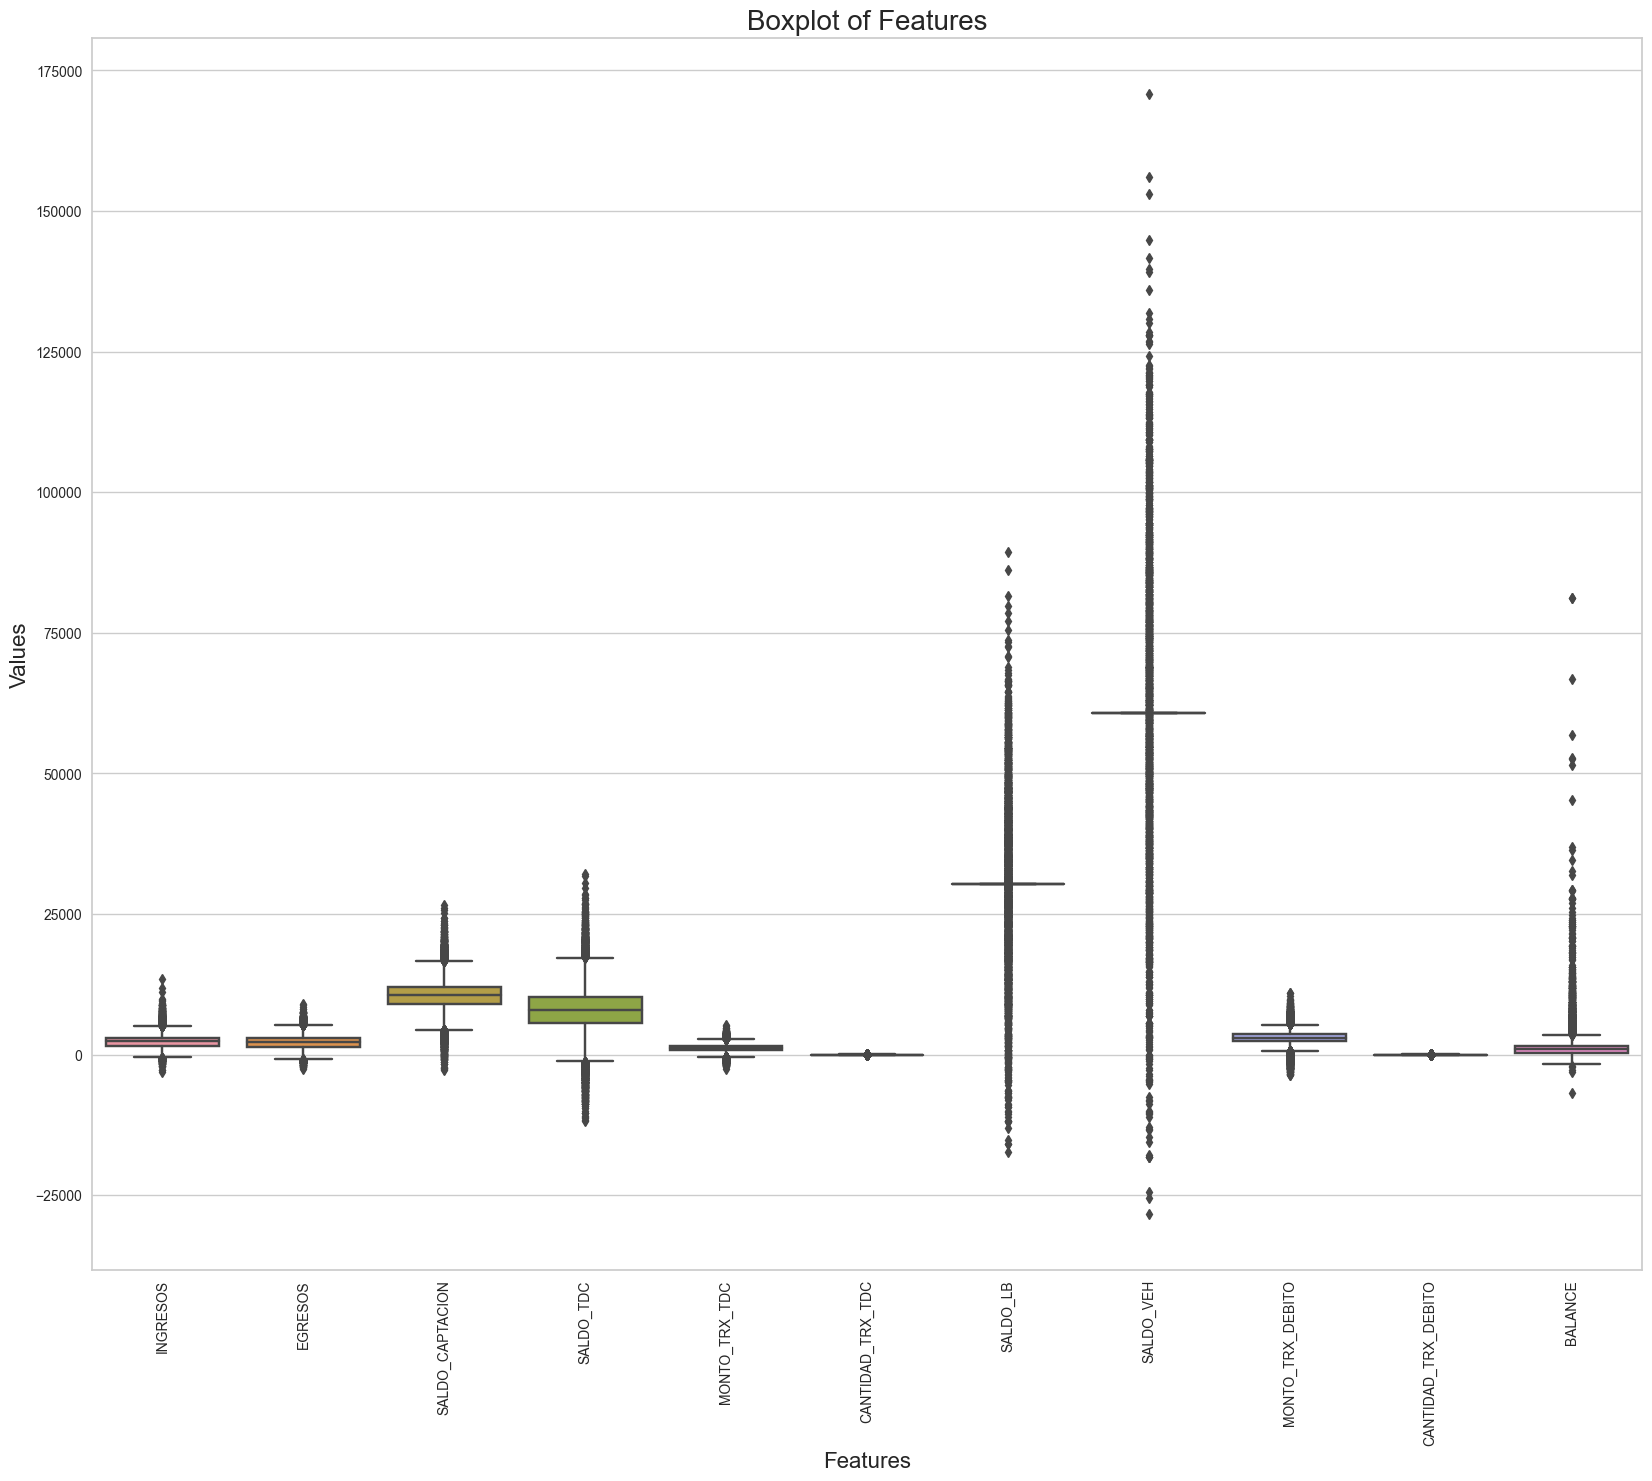

In [24]:
fig, ax = plt.subplots(figsize=(20, 16))
sns.boxplot(data=df1[list_columns[2:-4]], ax=ax)

ax.set_title('Boxplot of Features', fontsize=20)
ax.set_xlabel('Features', fontsize=16)
ax.set_ylabel('Values', fontsize=16)

plt.xticks(rotation=90)

plt.show()

Hay presencia de datos atipicos como es el caso de SALDO_VEH, SALDO_LB, BALANCE, etc. Para una mejor visualizacion del box-plot dejamos las variables que tienen rangos parecidos.

In [25]:
list_columns1 = list_columns.copy()
# remove the ID column from the list_columns1
list_columns1.remove('ID')
list_columns1.remove('AGE')
list_columns1.remove('SALDO_LB')
list_columns1.remove('SALDO_VEH')
list_columns1.remove('BALANCE')
print(list_columns1)

['INGRESOS', 'EGRESOS', 'SALDO_CAPTACION', 'SALDO_TDC', 'MONTO_TRX_TDC', 'CANTIDAD_TRX_TDC', 'MONTO_TRX_DEBITO', 'CANTIDAD_TRX_DEBITO', 'DURATION', 'CAMPAIGN', 'PDAYS', 'PREVIOUS']


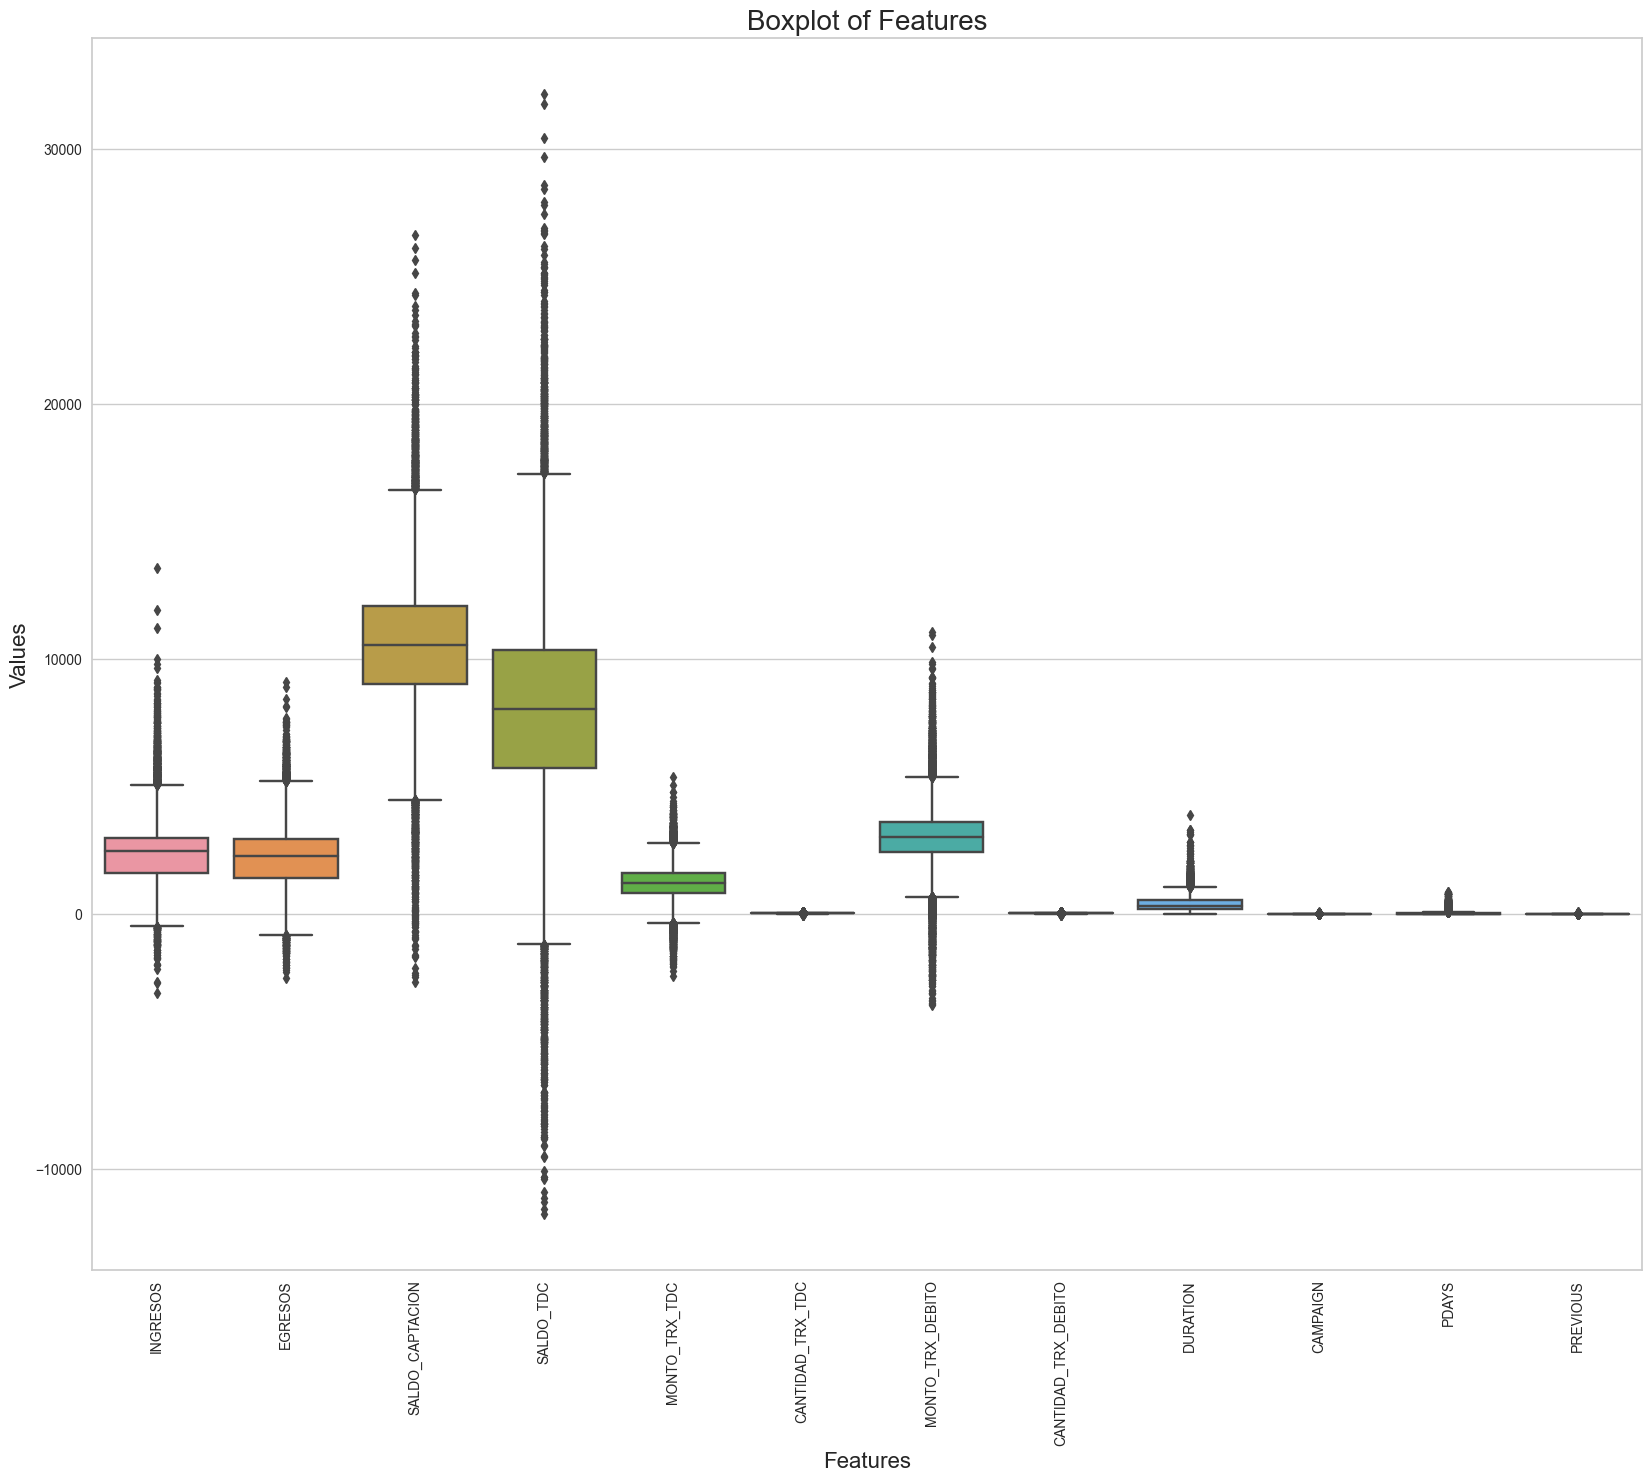

In [26]:
fig, ax = plt.subplots(figsize=(20, 16))
sns.boxplot(data=df1[list_columns1], ax=ax)

ax.set_title('Boxplot of Features', fontsize=20)
ax.set_xlabel('Features', fontsize=16)
ax.set_ylabel('Values', fontsize=16)

plt.xticks(rotation=90)

plt.show()

# Correlaciones

In [27]:
def stars(p):
    """
    Returns a string of asterisks (*) based on the significance level (alpha value) of a statistical test.

    Args:
        p (float): the p-value of the statistical test

    Returns:
        A string of asterisks indicating the significance level, as follows:
        - five asterisks (*****): alpha value is 0.0001 or 0.01% with 99.99% confidence
        - four asterisks (****): alpha value is 0.001 or 0.1% with 99.9% confidence
        - three asterisks (***): alpha value is 0.01 or 1% with 99% confidence
        - two asterisks (**): alpha value is 0.05 or 5% with 95% confidence
        - one asterisk (*): alpha value is 0.1 or 10% with 90% confidence
        - empty string (''): alpha value is greater than or equal to 0.1
    """
    if p < 0.0001:
        return '*****'
    elif p < 0.001:
        return '****'
    elif p < 0.01:
        return '***'
    elif p < 0.05:
        return '**'
    elif p < 0.1:
        return '*'
    else:
        return ''

In [28]:
def plot_correlations(dataframe, corr_methods):
    for method in corr_methods:
        stroke = withStroke(linewidth=2, foreground='black')
        corr_matrix = dataframe.corr(method=method)
        pval_matrix = dataframe.corr(method=lambda x, y: stats.pearsonr(x, y)[1])

        # Create a mask to show only the lower triangle of the matrix
        mask = np.triu(np.ones_like(corr_matrix))
        mask2 = np.tril(np.ones_like(corr_matrix))
        stars_corr = pval_matrix * mask2 + mask
        pval_stars = stars_corr.applymap(stars)
        color_palette = sns.color_palette("Blues")
        with sns.axes_style("whitegrid"):
            f, ax = plt.subplots(figsize=(12, 10))
            ax = sns.heatmap(corr_matrix.round(4),
                             mask=mask,
                             vmax=1,
                             center=0,
                             vmin=-1,
                             square=True,
                             cmap=sns.cubehelix_palette(8, start=.5, rot=-.75, as_cmap=True),
                             linewidths=.5,
                             annot=True,
                             annot_kws={"size": 12},
                             fmt='.2f')
            ax.set_title(f'{method.capitalize()} Correlations Matrix', fontsize=20)
            plt.xticks(fontsize=9)
            plt.yticks(fontsize=9)
            
            for i, j in itertools.product(range(corr_matrix.shape[0]), range(corr_matrix.shape[0])):
                ax.text(j + 0.5, i + 0.8, pval_stars.iloc[i, j], ha='center', va='center', color='white', fontsize=18,path_effects=[stroke])

            plt.savefig(current_path.joinpath(f'correlation_vi_{method.capitalize()}_triangular_stage.png'), dpi=300, bbox_inches='tight')
            plt.savefig(current_path.joinpath(f'correlation_vi_{method.capitalize()}_triangular_stage.eps'), dpi=300, format='eps', bbox_inches='tight')
            plt.show()

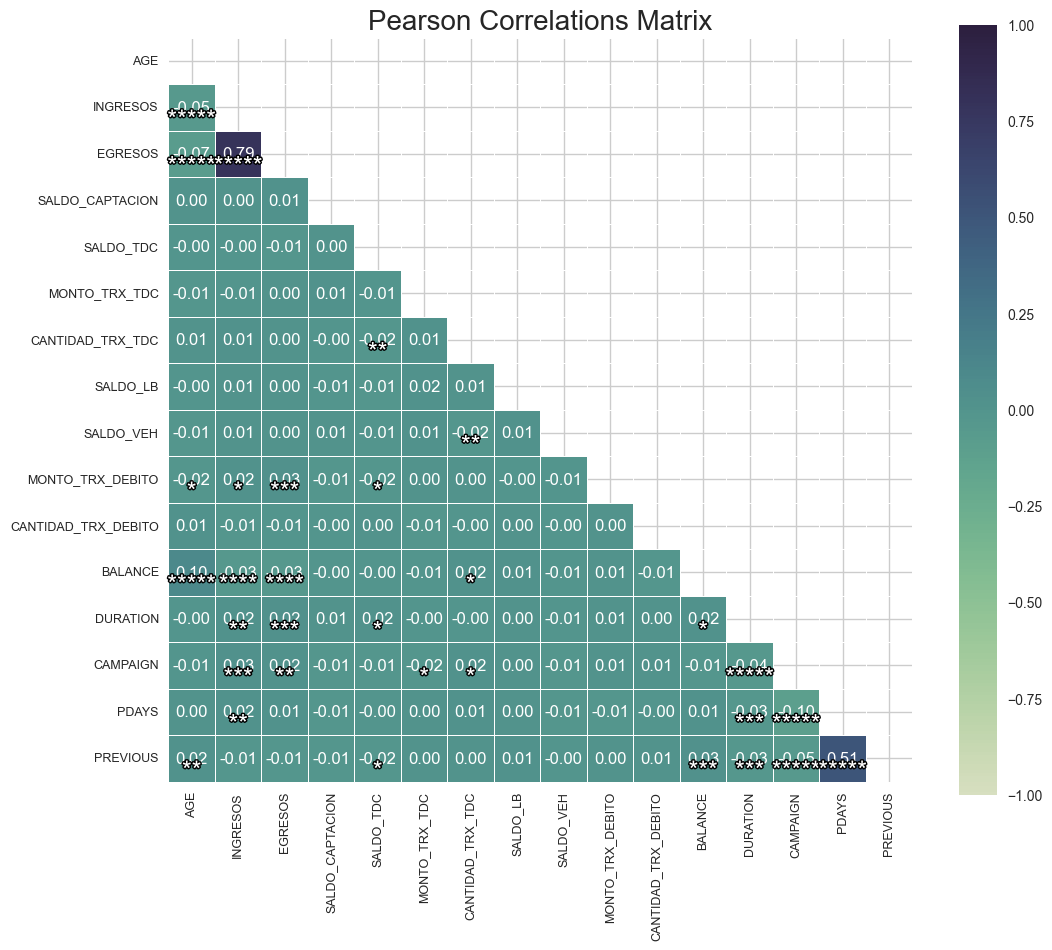

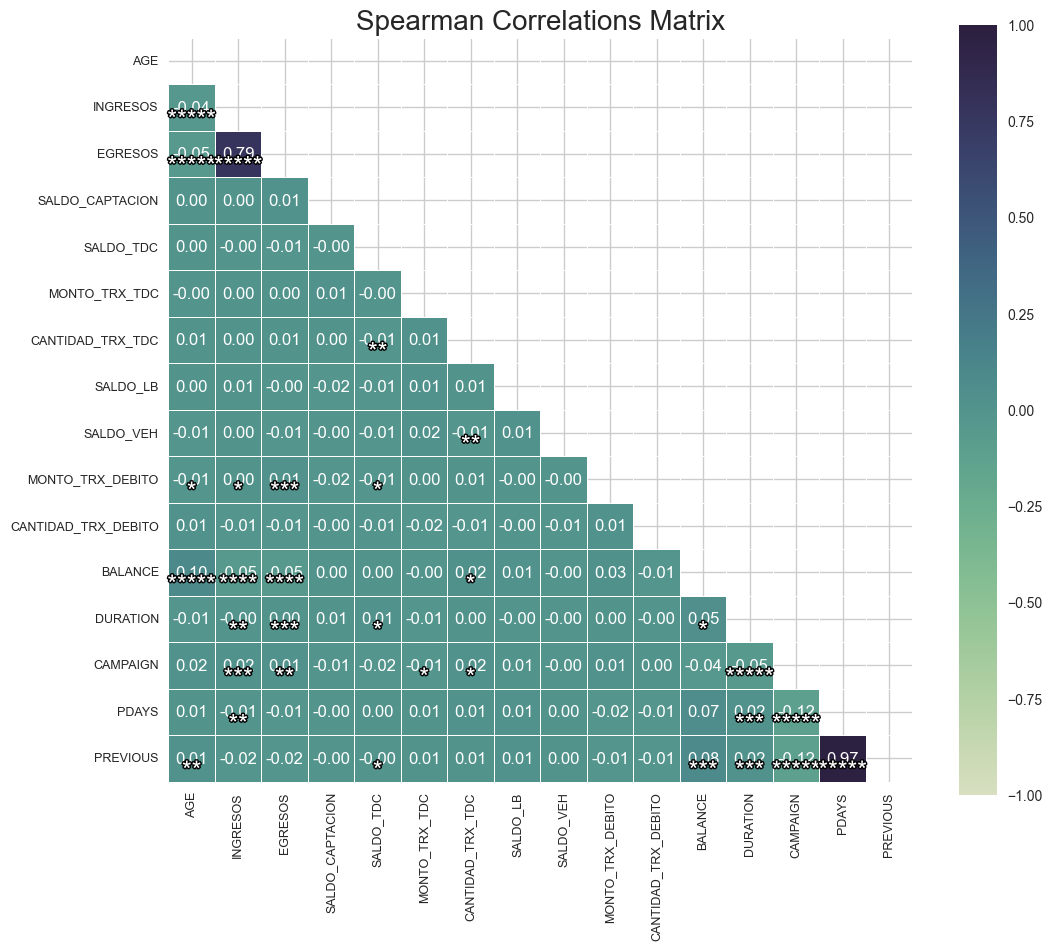

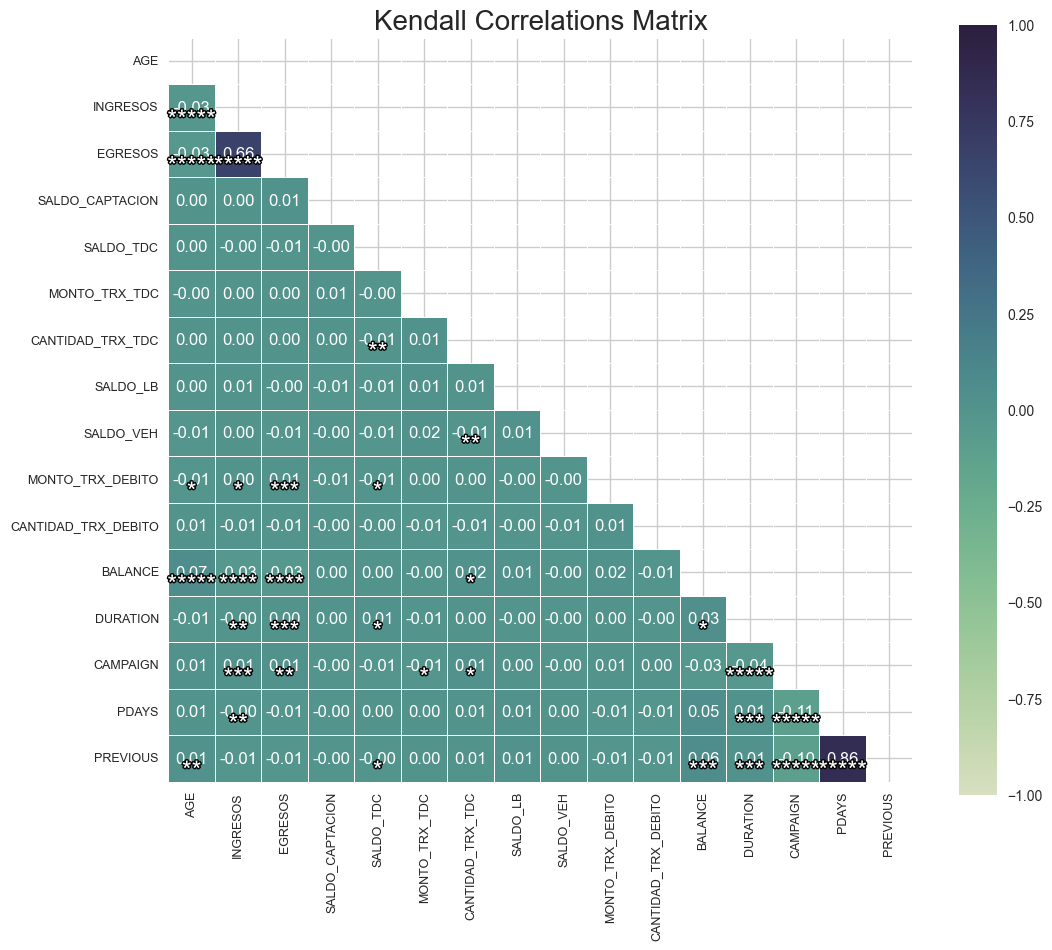

In [29]:
correlation_methods = ['pearson','spearman','kendall']
plot_correlations(df1[list_columns[1:]],correlation_methods)

Las variables numéricas no presentan alguna correlacion entre ellas, por lo que se puede decir que son independientes.

# Variables predictoras LOAN y HOUSING

In [30]:
# Proporciones de la variable objetivo 1
df1['LOAN'].value_counts(normalize=True)*100

LOAN
0    86.919907
1    13.080093
Name: proportion, dtype: float64

In [31]:
# Proporciones de la variable objetivo 2
df1['HOUSING'].value_counts(normalize=True)*100

HOUSING
0    52.68769
1    47.31231
Name: proportion, dtype: float64

Las Clases de las variables objetivo están desbalanceadas (Unbalanced Dataset), por lo que se debe tener cuidado al momento de entrenar los modelos. En el caso de LOAN tenemos una proporcion 86.9% de la clase 0 y 13% de la clase 1. En el caso de HOUSING tenemos una proporcion 52.6% de la clase 0 y 47.3% de la clase 1.

# Analisis bivariado

In [32]:
def bivariate_analysis_categorical(df, var_target, var_categorical):
    for col in var_categorical:
        print(pd.crosstab(df[col],df[var_target]))
        feature = pd.crosstab(df[col],df[var_target])
        feature.div(feature.sum(1).astype(float),axis=0).plot(kind="bar",stacked=True,figsize=(4,4))
        plt.xlabel(col)
        plt.ylabel(var)
        plt.show()

LOAN     0    1
JOB            
0     2306  260
1     1607  337
2     1575  248
3     1098  236
4      769  154
5      723   55
6      349   56
7      359    1
8      336   21
9      258   70
10     254   20
11      68    2


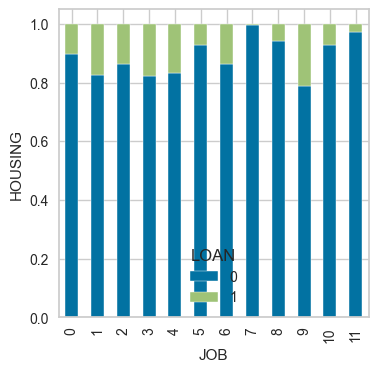

LOAN        0    1
MARITAL           
0        4306  732
1        2513  277
2        2001  294
3         882  157


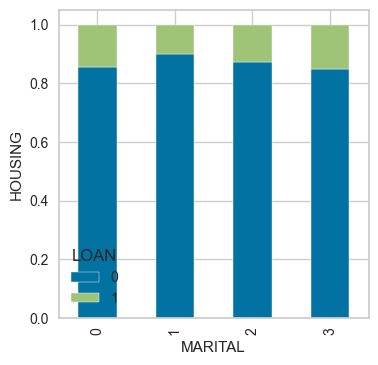

LOAN          0    1
EDUCATION           
0          3672  706
1          2666  296
2          2328  297
3          1036  161


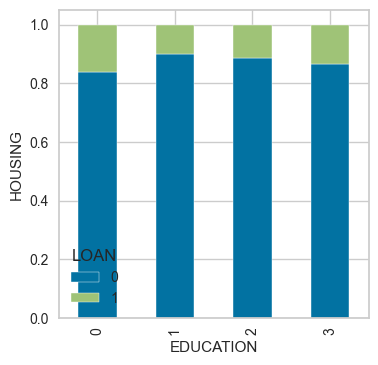

LOAN        0     1
CONTACT            
0        6991  1051
1        2019   327
2         692    82


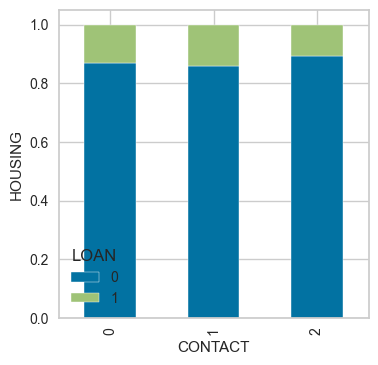

LOAN         0     1
POUTCOME            
0         7139  1187
1         1060   168
2         1020    51
3          483    54


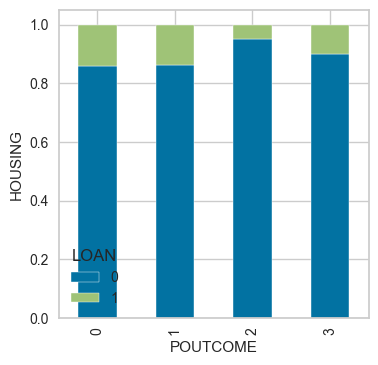

LOAN        0     1
DEFAULT            
0        9591  1403
1         111    57


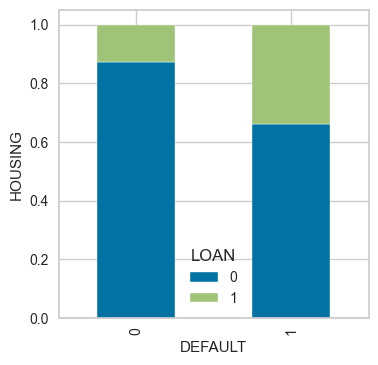

LOAN        0    1
DEPOSIT           
0        4897  976
1        4805  484


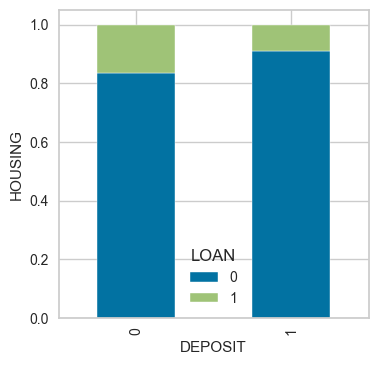

LOAN                 0     1
TENENCIA_AHORROS            
0.0               6922  1012
1.0               2780   448


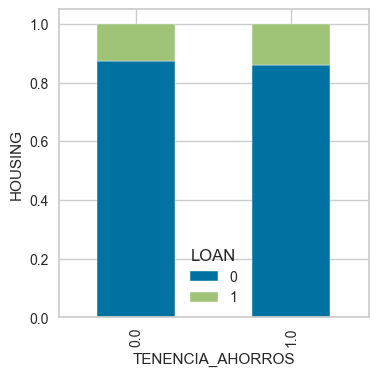

LOAN                   0     1
TENENCIA_CORRIENTE            
0.0                 8765  1317
1.0                  937   143


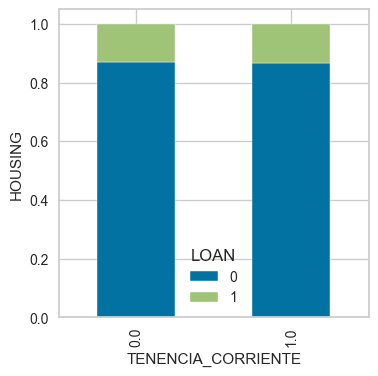

LOAN             0     1
TENENCIA_CDT            
0.0           7406  1128
1.0           2296   332


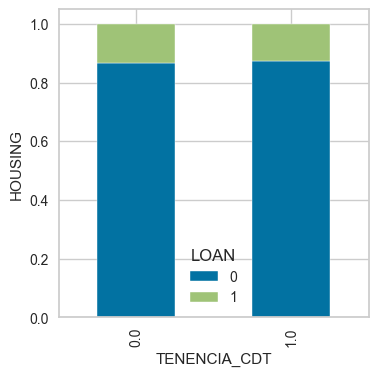

LOAN             0     1
TENENCIA_TDC            
0.0           7802  1195
1.0           1900   265


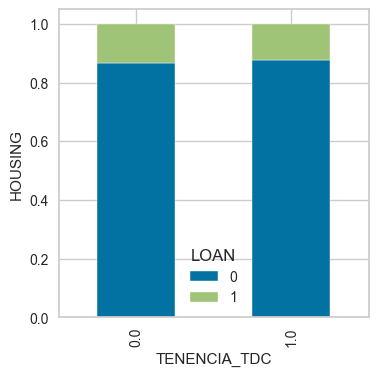

LOAN            0     1
TENENCIA_LB            
0.0          6921  1043
1.0          2781   417


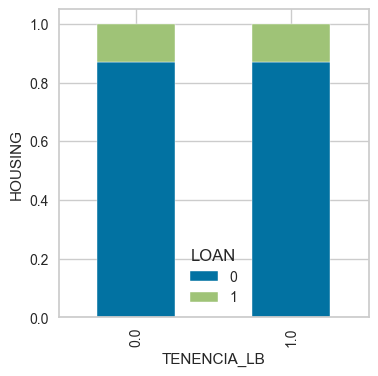

LOAN                  0     1
TENENCIA_VEHICULO            
0.0                7839  1194
1.0                1863   266


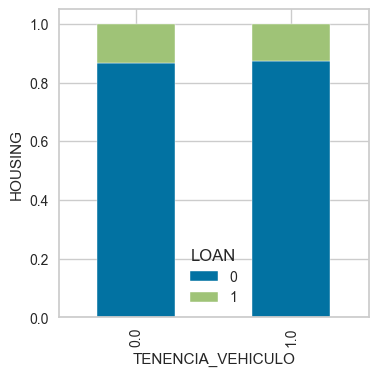

In [33]:
bivariate_analysis_categorical(df1,'LOAN',var_categoricas[:-2])

In [ ]:
bivariate_analysis_categorical(df1,'HOUSING',var_categoricas[:-2])

Información de LOAN con las indicaciones de aprobación de créditos de libranza

- Las personas con tipo de empleo Blue-collar (Trabajos Manuales/Albañil) 337
- Las personas casadas 732
- Las personas con educación secundaria 706
- Las personas que han sido contactadas por Celular 1051
- Las personas cuyo resultado de la última campaña fue desconocido 1187
- Las personas que no han estado con créditos en mora 1403
- Las Personas que no tienen tarjeta debito 976
- Las personas que no tienen cuentas de ahorros 1012
- Las personas que no tienen cuentas corrientes 1317
- Las personas que no tienen CDT 1128
- Las personas que no tienen tarjetas de crédito 1195
- Las personas que no tienen créditos Libre inversión 1043
- Las personas que no tienen vehículos 1194


información de HOUSING con las indicaciones de aprobación de créditos de vivienda

- Las personas con tipo de empleo Blue-collar (Trabajos Manuales/Albañil) 1321
- Las personas casadas 2453
- Las personas con educación secundaria 2338
- Las personas que han sido contactadas por Celular 3351
- Las personas cuyo resultado de la última campaña fue desconocido 3998
- Las personas que no han estado con créditos en mora 5194
- Las personas que no tienen tarjetas debido 3346
- Las personas que no tienen cuentas de ahorros 3760
- Las personas que no tienen cuentas corrientes 4770
- Las personas que no tienen CDT 4018
- Las personas que no tienen tarjetas de crédito 4226
- Las personas que no tienen créditos Libre inversión 3750
- Las personas que no tienen vehículos 4250

__Hipótesis 1:__ La información relacionada con las campañas no es significativa dada la situación de desconocida. Puede considerarse la opción de quitar las columnas relacionadas con campañas pdays, poutcome, previous, campaing.

__Hipótesis 2:__ Es muy sospechoso que la aprobación más alta está relacionada con No tener ciertos productos financieros, esto puede indicar 2 cosas. La primera que la asignación Booleana de estas variables signifique 0 es TRUE y 1 es FALSE. 2 De ser así la imputación de los datos debe hacer un fillna(1). El problema no es lo suficientemente claro en este aspecto.


In [34]:
def bivariate_analysis_numerical(df, var_target, var_numerical):
    for col in var_numerical:
        sns.boxplot(x=var_target,y=col,data=df)
        plt.show()

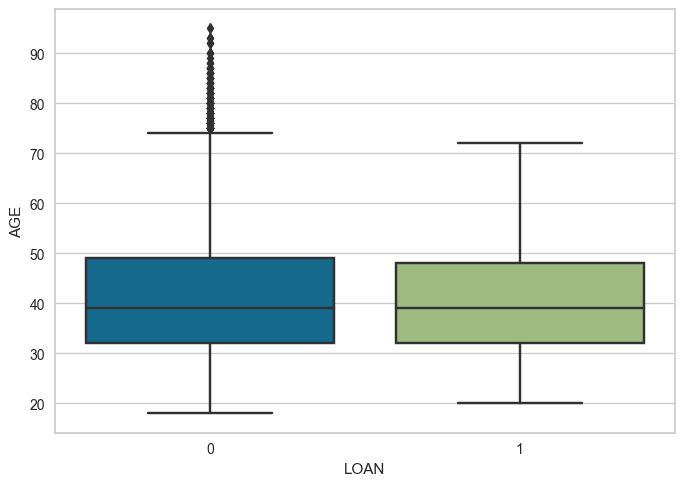

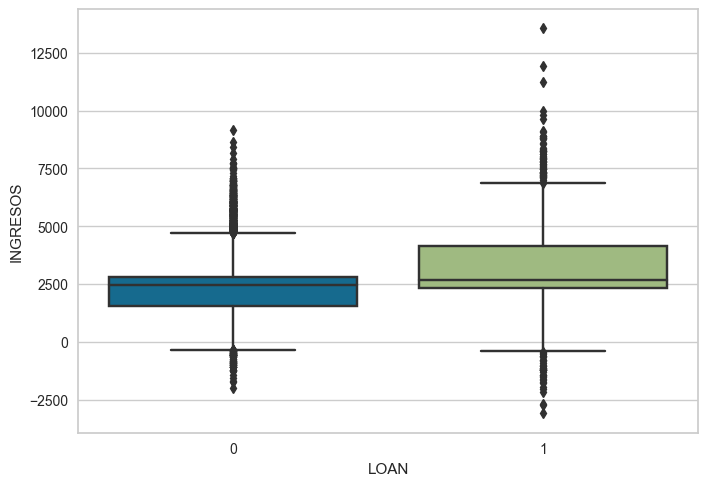

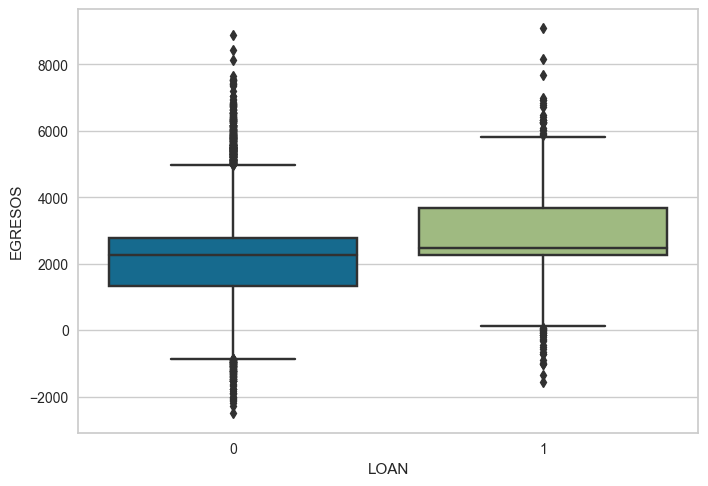

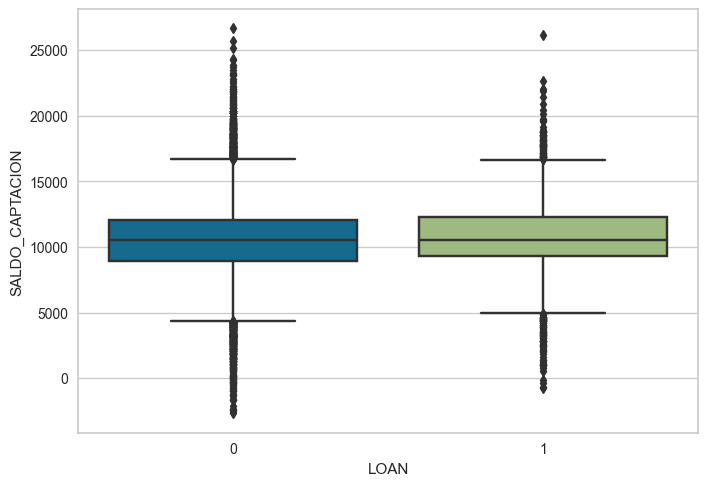

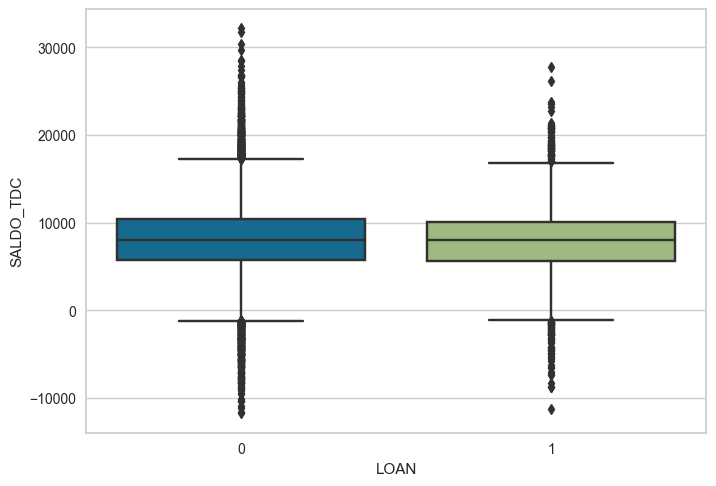

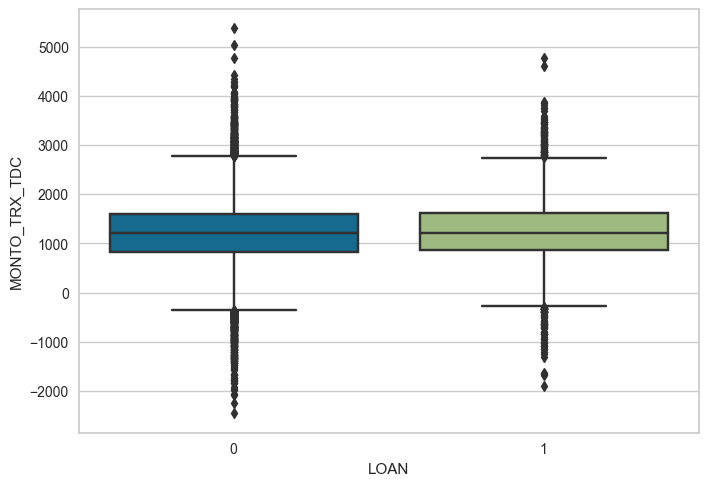

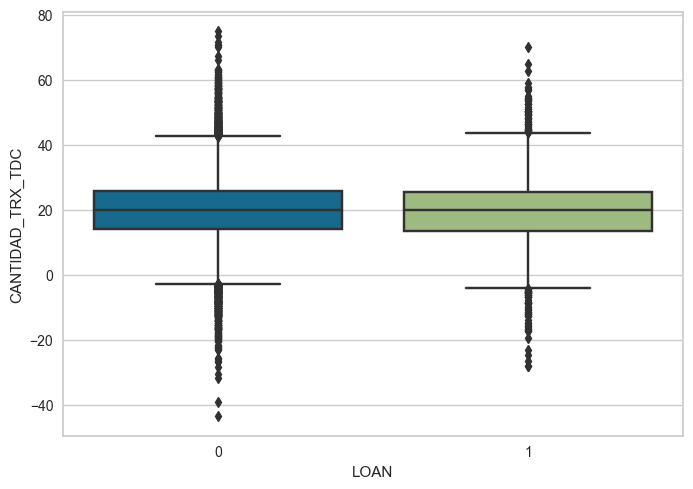

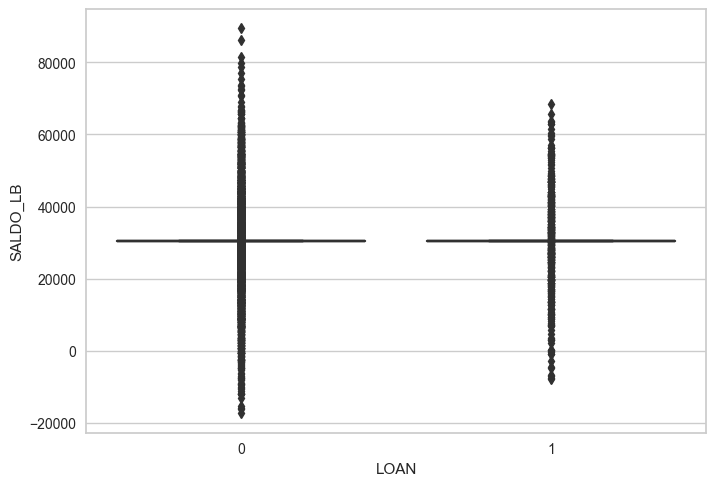

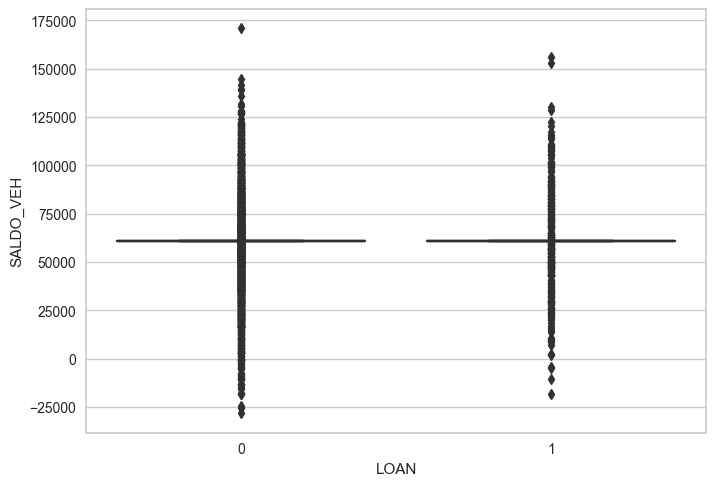

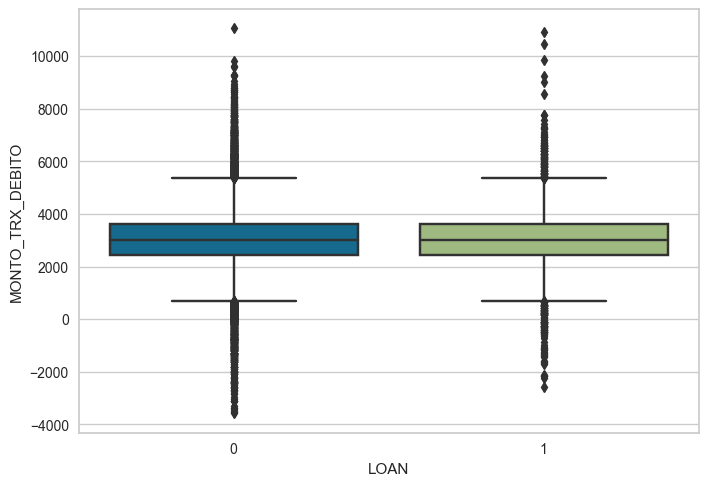

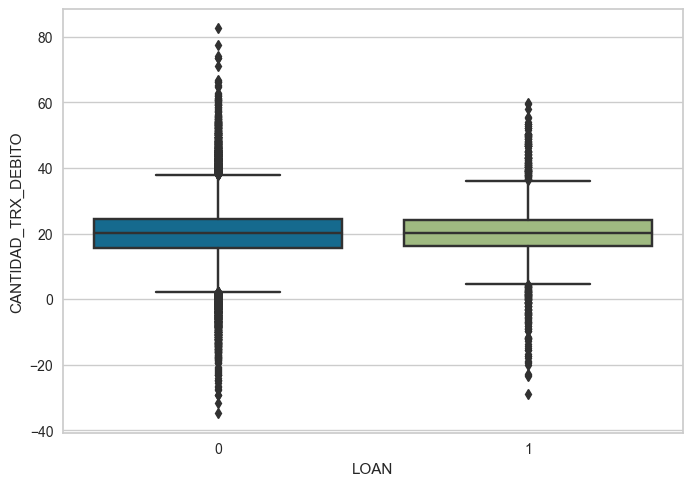

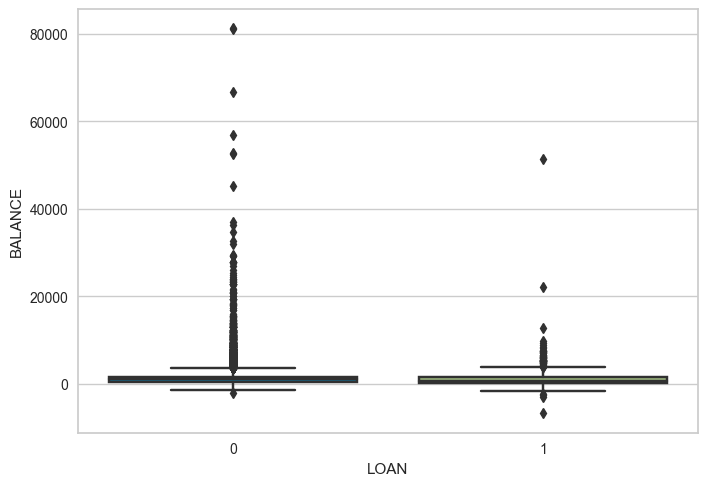

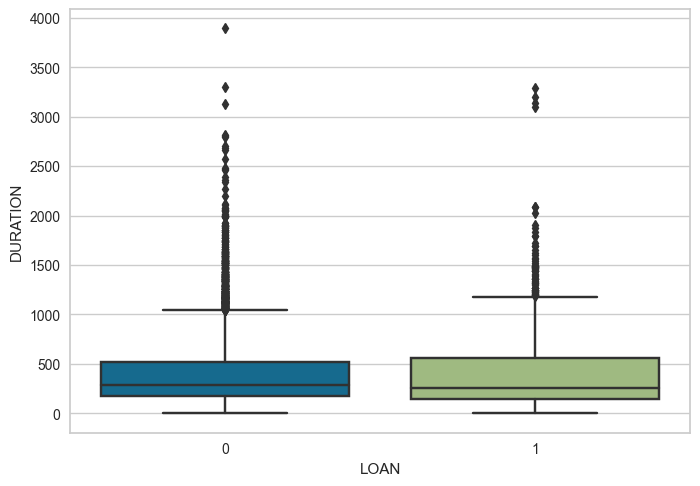

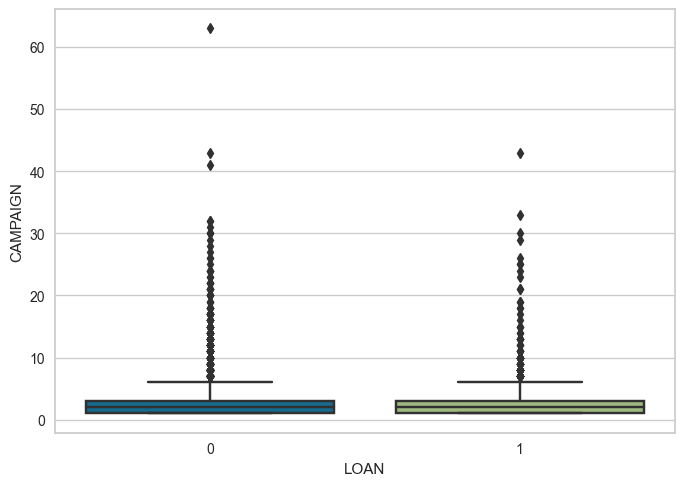

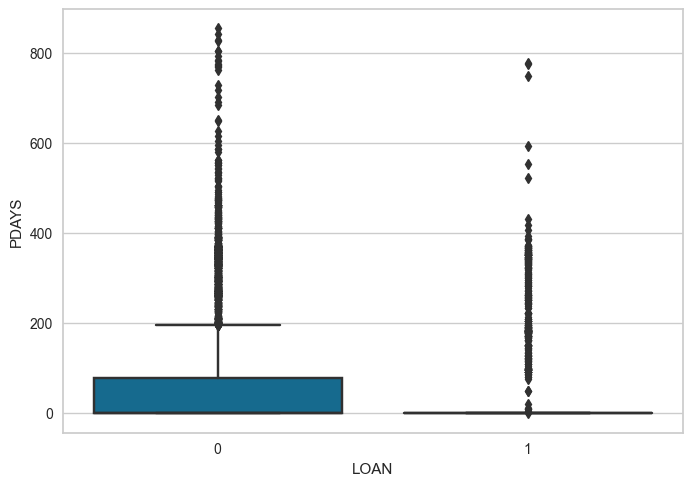

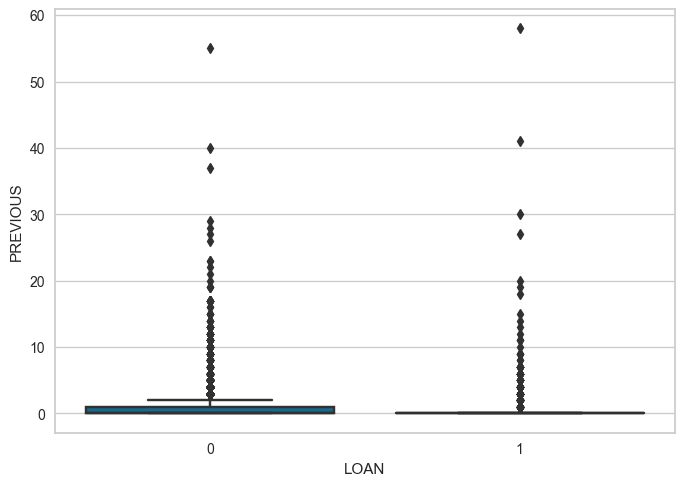

In [35]:
bivariate_analysis_numerical(df1,'LOAN',list_columns[1:])

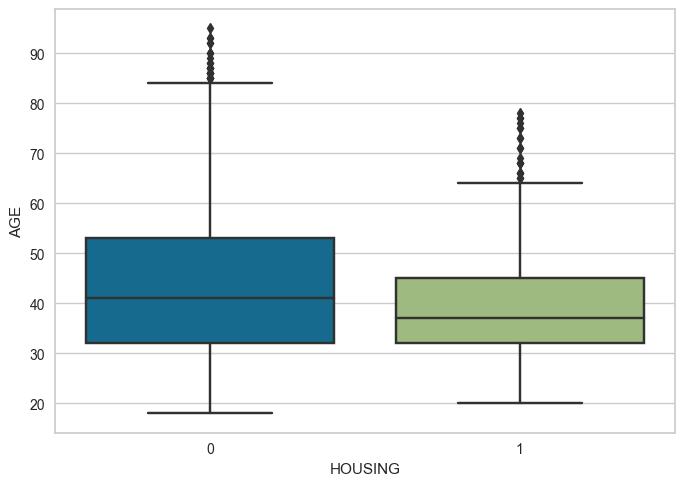

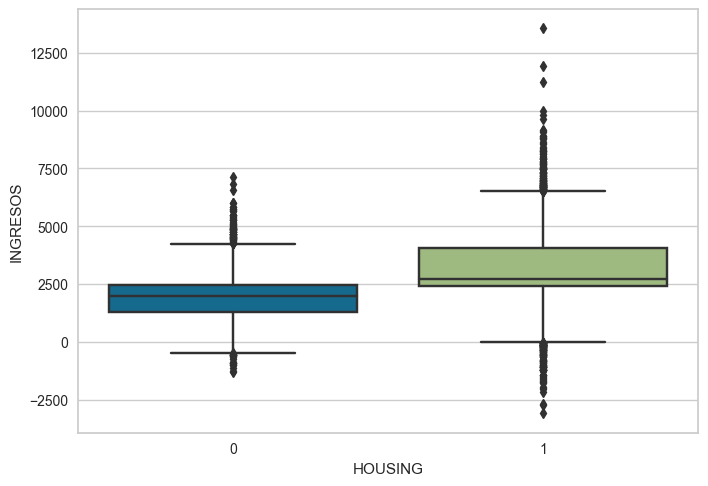

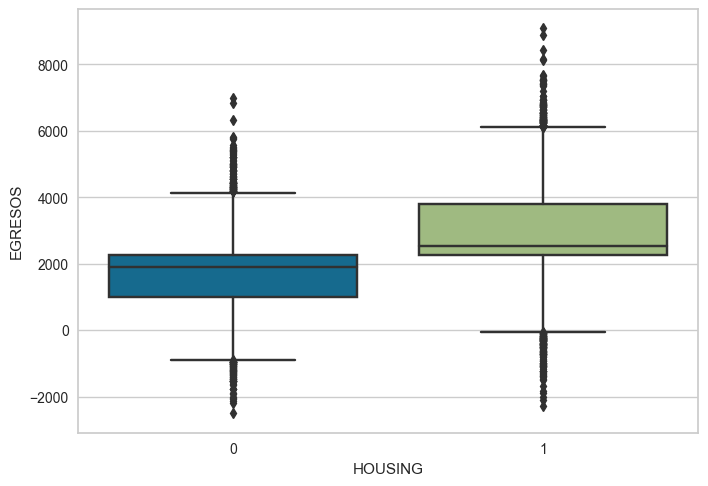

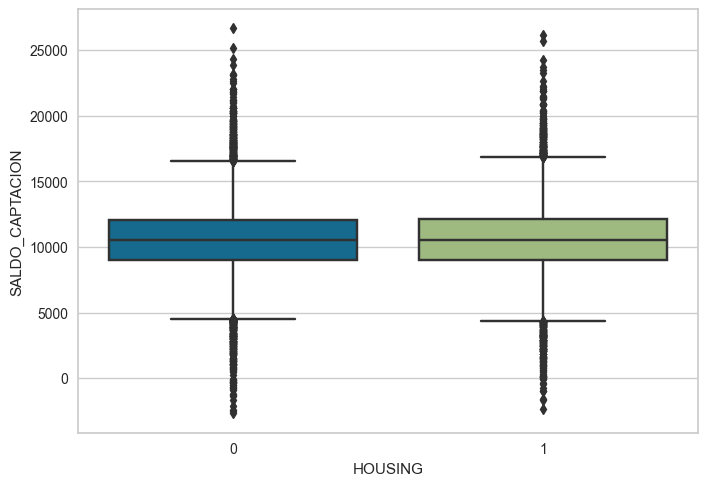

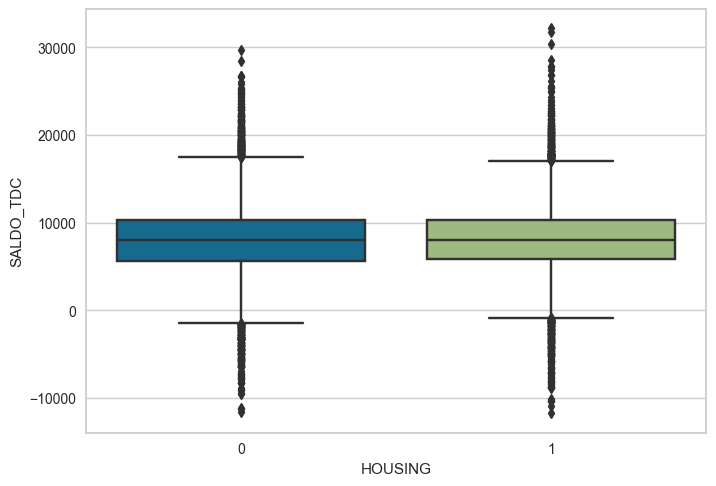

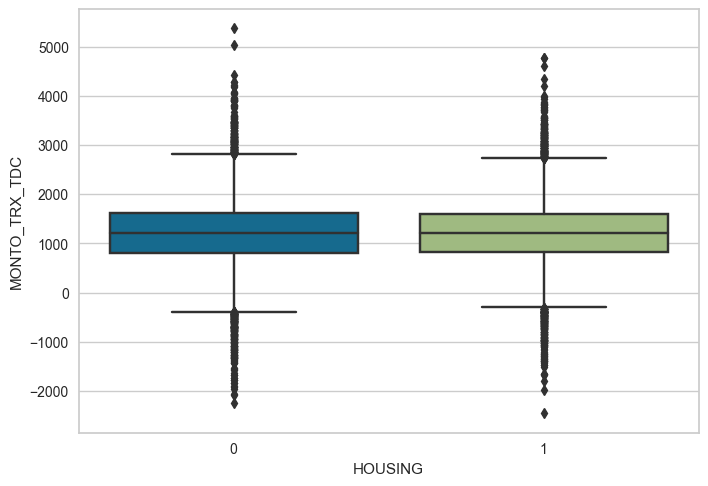

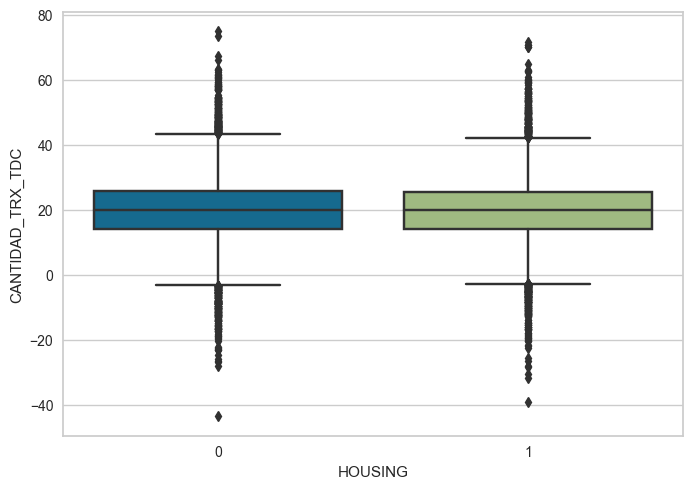

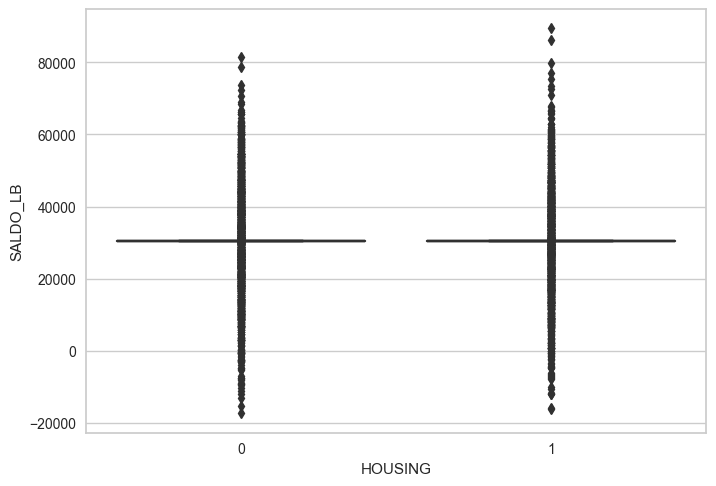

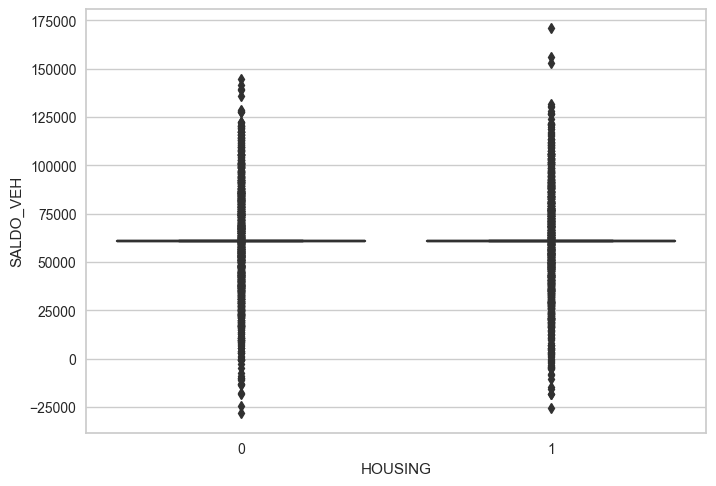

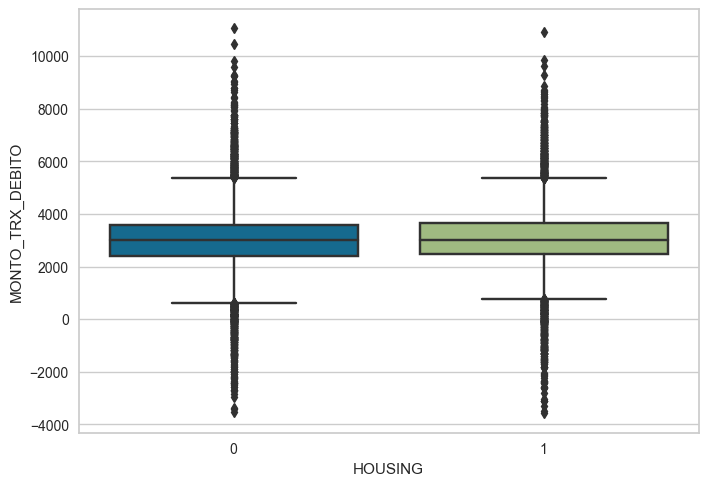

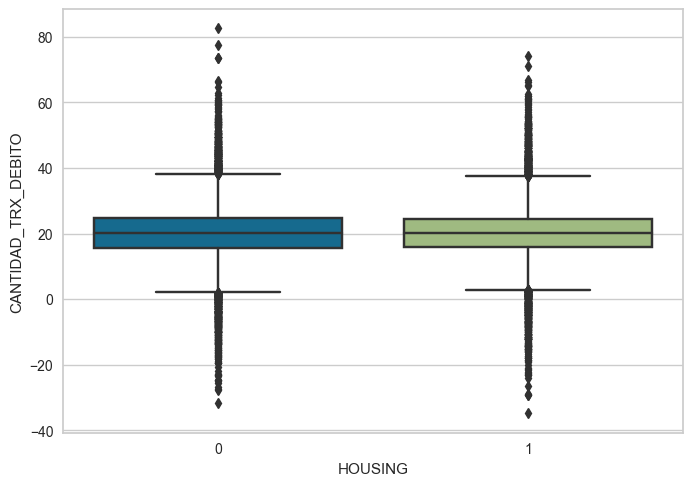

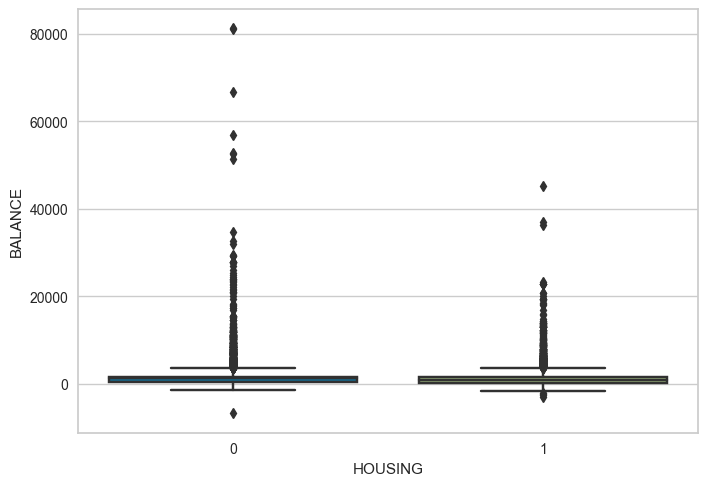

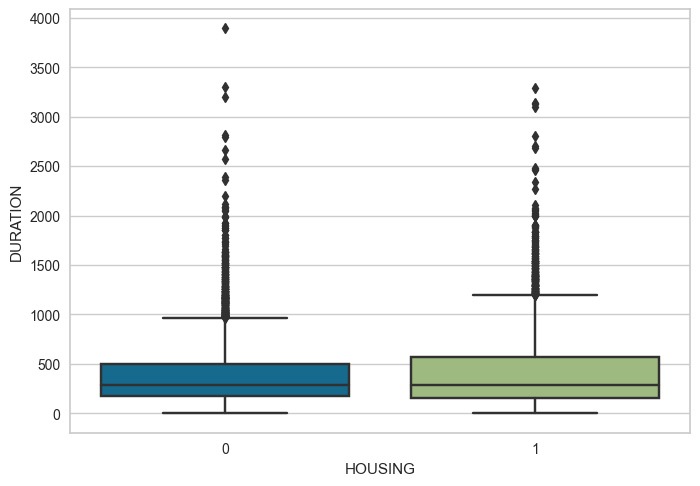

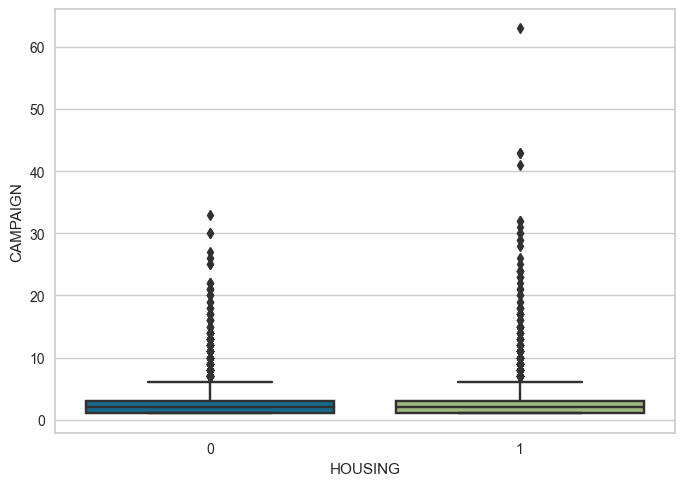

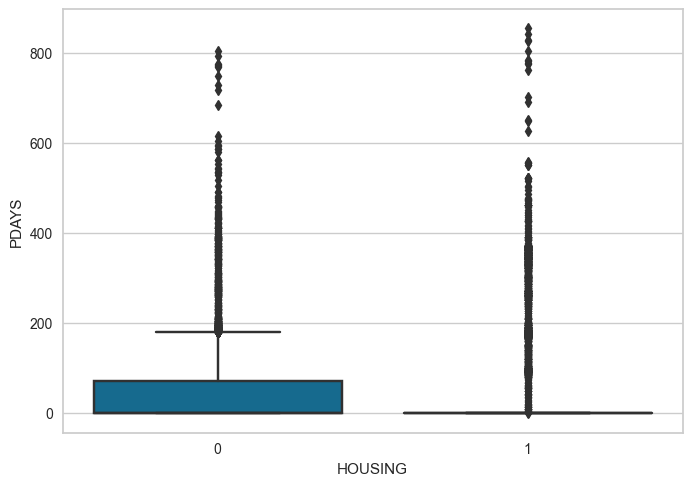

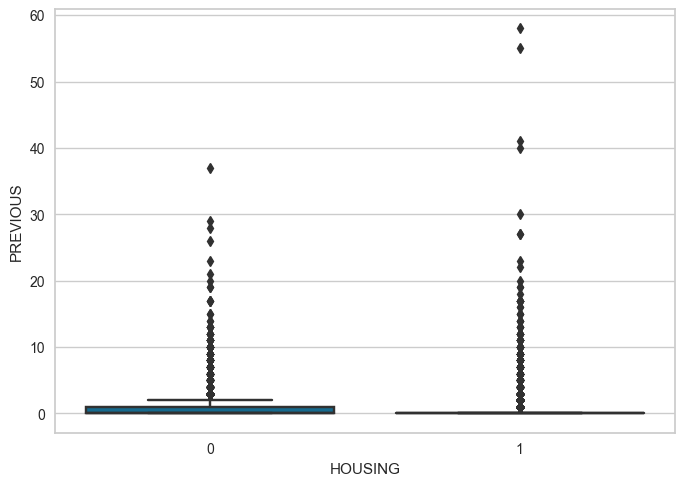

In [36]:
bivariate_analysis_numerical(df1,'HOUSING',list_columns[1:])

# Outliers

Como se observo en los graficos de distribución de las variables numericas, las variables tienen el siguiente comportamiento:

- INGRESOS tiene una forma normal
- EGRESOS tiene una forma normal
- SALDO_CAPTACION tiene una forma normal
- SALDO_TDC tiene una forma normal
- MONTO_TRX_TDC tiene una forma normal
- CANTIDAD_TRX_TDC tiene una forma normal
- SALDO_LB tiene una forma normal
- SALDO_VEH tiene una forma normal
- MONTO_TRX_DEBITO tiene una forma normal
- CANTIDAD_TRX_DEBITO tiene una forma normal
- BALANCE tiene asimetria a la derecha
- DURATION tiene asimetria a la derecha
- CAMPAIGN tiene asimetria a la derecha
- PDAYS tiene asimetria a la derecha
- PREVIOUS tiene asimetria a la derecha


Hacemos una transformacion de las variables con la función logaritmo para que tenga una forma normal.

In [37]:
list_columns[2:]

['INGRESOS',
 'EGRESOS',
 'SALDO_CAPTACION',
 'SALDO_TDC',
 'MONTO_TRX_TDC',
 'CANTIDAD_TRX_TDC',
 'SALDO_LB',
 'SALDO_VEH',
 'MONTO_TRX_DEBITO',
 'CANTIDAD_TRX_DEBITO',
 'BALANCE',
 'DURATION',
 'CAMPAIGN',
 'PDAYS',
 'PREVIOUS']

# Outliers por desviacion estandar

In [38]:
def remove_outliers_std(df, column_name, num_std=3):
    mean = df[column_name].mean()
    std = df[column_name].std()
    df = df[(df[column_name] >= mean - num_std * std) & (df[column_name] <= mean + num_std * std)]
    return df

In [39]:
for col in list_columns[2:-5]:
    df1 = remove_outliers_std(df1, col, num_std=3)

In [40]:
print('El dataset tiene un tamaño de: ',df1.shape)

El dataset tiene un tamaño de:  (9751, 32)


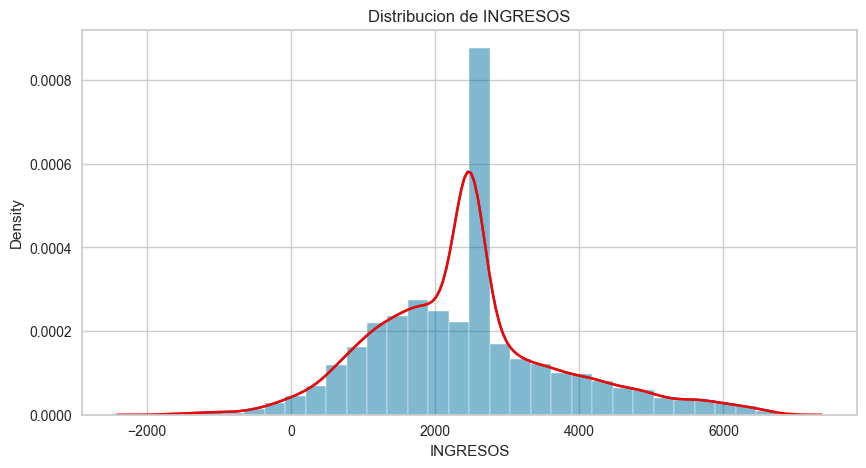

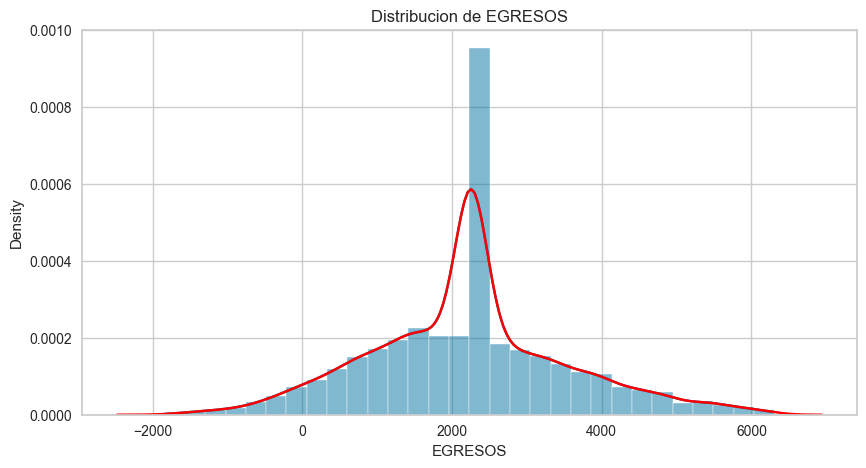

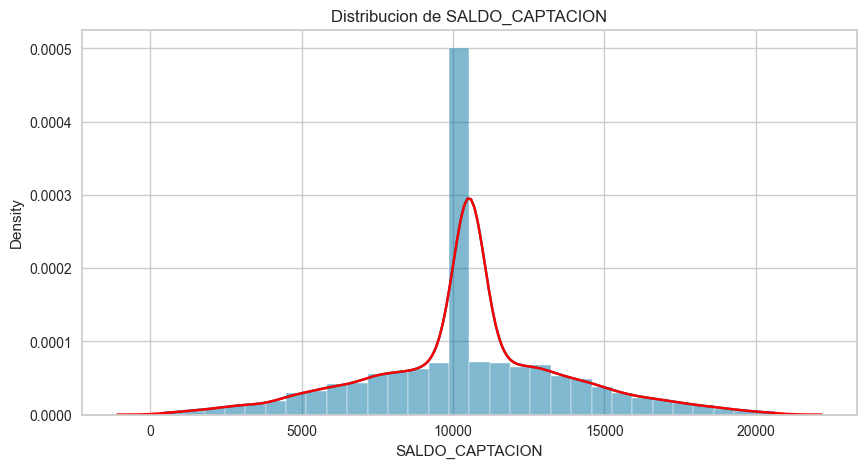

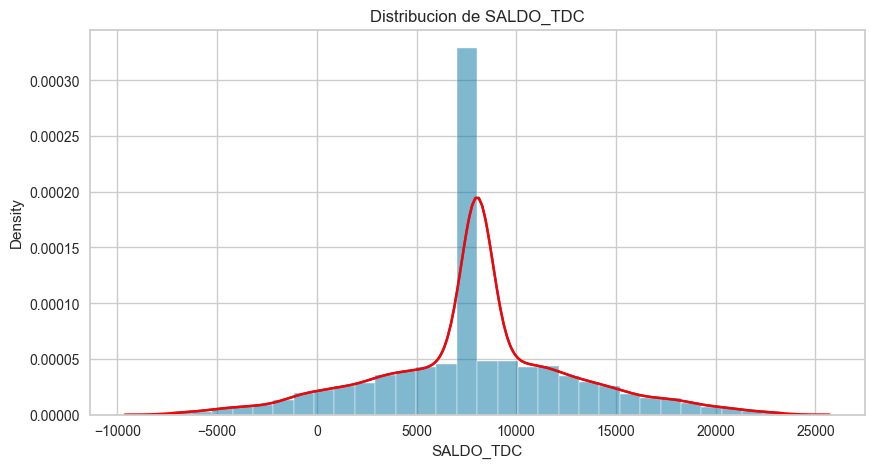

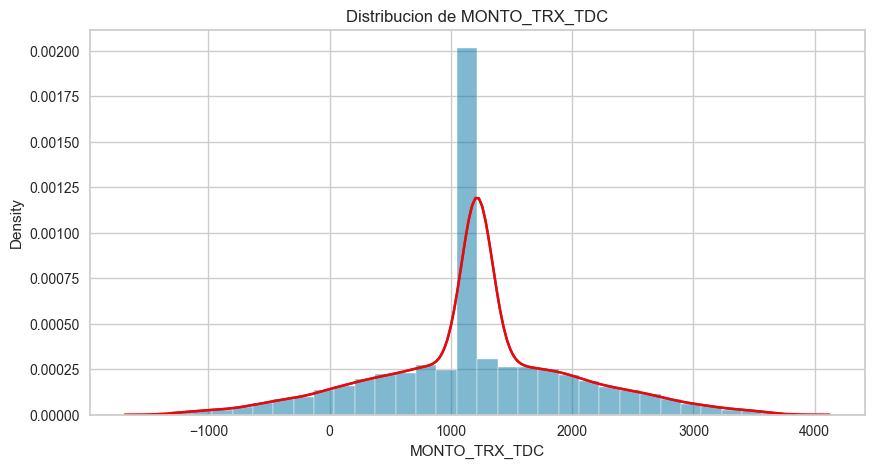

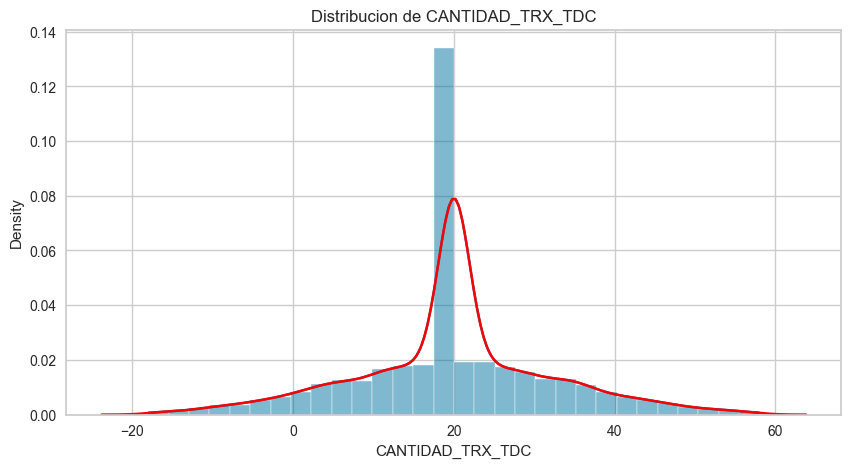

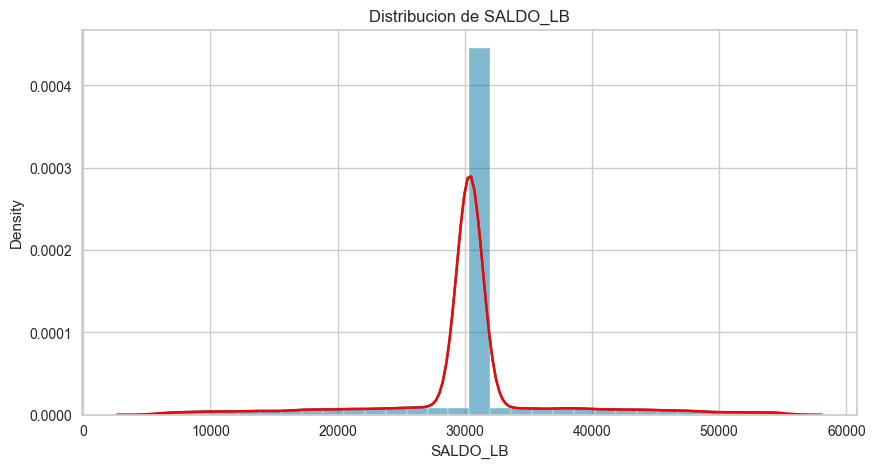

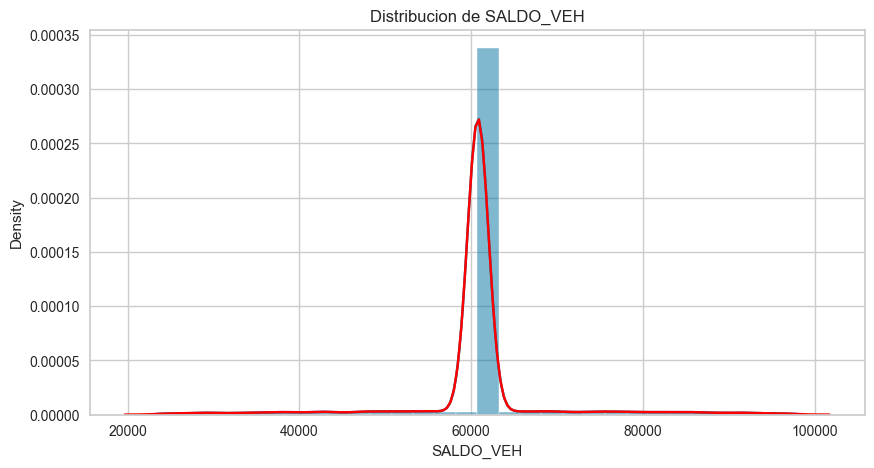

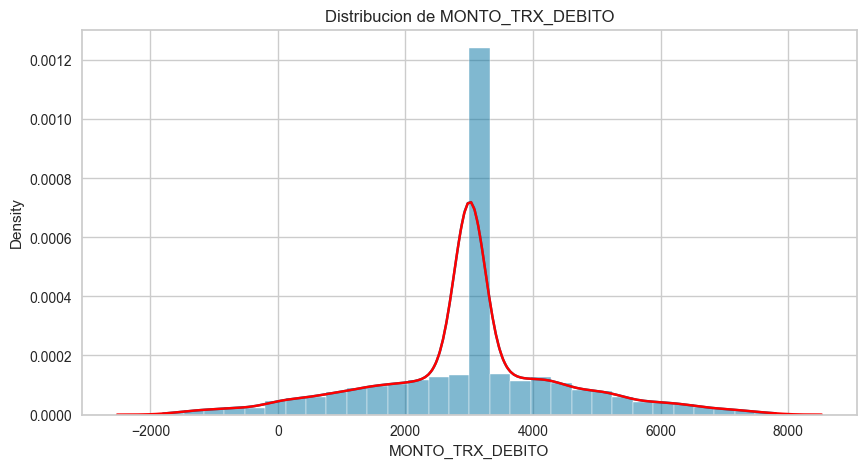

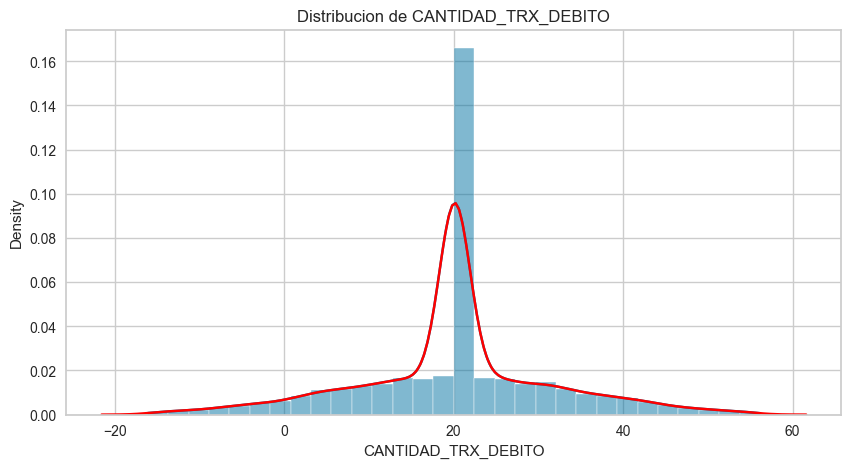

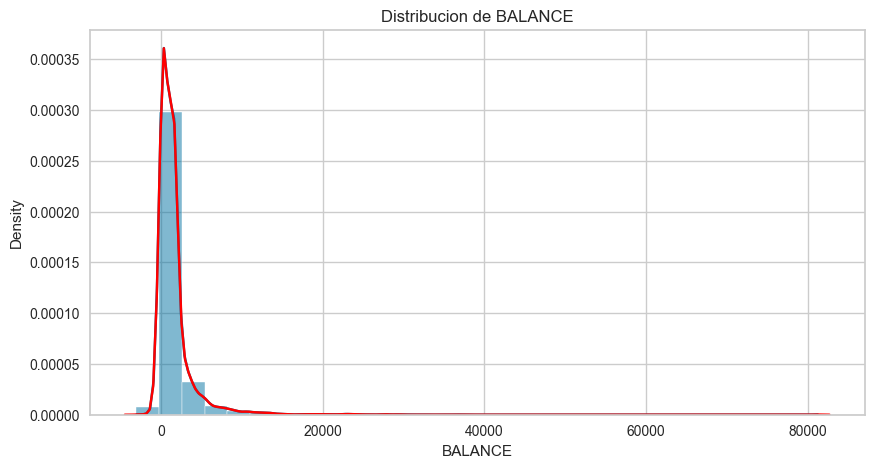

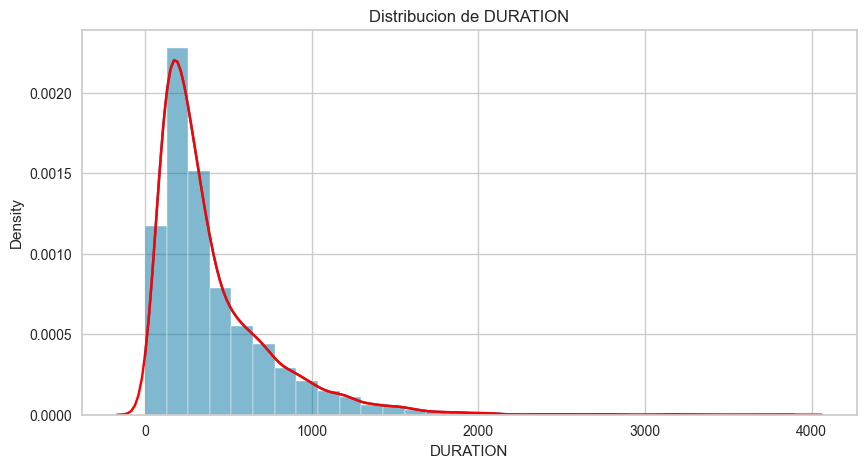

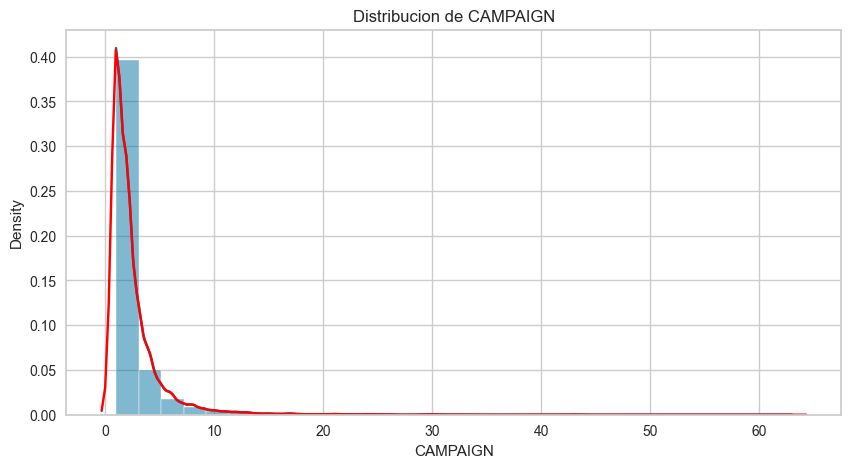

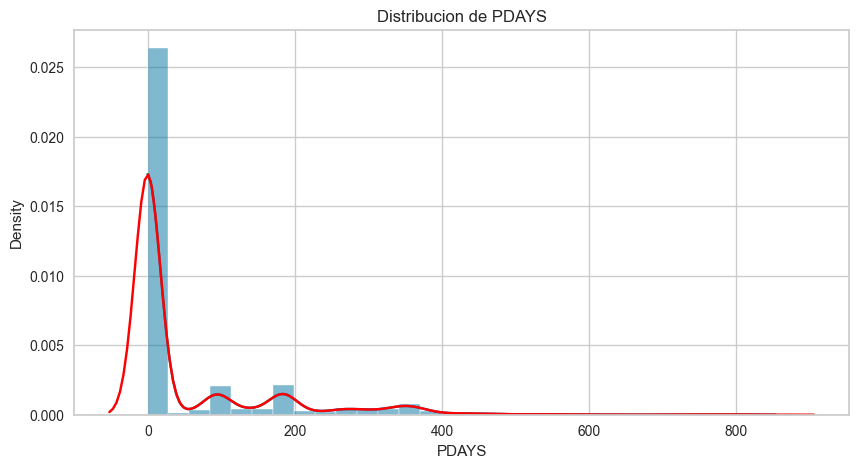

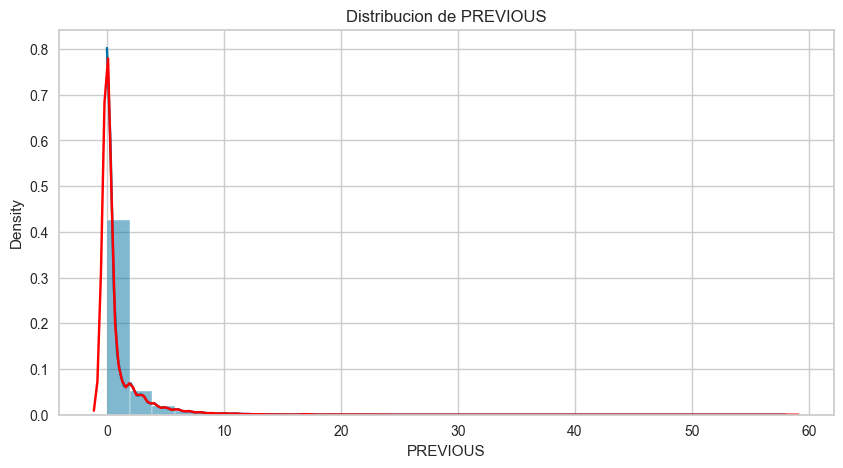

In [41]:
for col in list_columns[2:]:
    plt.figure(figsize=(10, 5))
    plt.title(f'Distribucion de {col}')
    sns.histplot(df1[col], bins=30, kde=True, stat='density')
    sns.kdeplot(df1[col], color='red')
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.savefig(f'density_{col}_plot.png')
    plt.show()

In [42]:
df1.head(100)

ID  AGE JOB MARITAL EDUCATION DEFAULT CONTACT POUTCOME DEPOSIT  \
0      0   59   3       0         0       0       1        0       1   
1      1   56   3       0         0       0       1        0       1   
2      2   41   2       0         0       0       1        0       1   
3      3   55   4       2         0       0       1        0       1   
4      4   54   3       0         1       0       1        0       1   
..   ...  ...  ..     ...       ...     ...     ...      ...     ...   
112  112   32   2       0         2       0       1        0       1   
113  113   36   0       0         1       0       1        0       1   
114  114   30   1       2         0       1       1        0       1   
115  115   37   2       1         0       0       1        0       1   
116  116   36   1       2         3       0       1        0       1   

    TENENCIA_AHORROS  ...     SALDO_VEH MONTO_TRX_DEBITO CANTIDAD_TRX_DEBITO  \
0                0.0  ...  40855.619940      4004.988678           26.806785   
1                0.0  ...  60792.063848      7126.370878           20.132298   
2                0.0  ...  60792.063848      3009.643796           20.132298   
3                0.0  ...  60792.063848      5466.849819            9.389375   
4                1.0  ...  60792.063848      3009.643796           20.132298   
..               ...  ...           ...              ...                 ...   
112              0.0  ...  60792.063848       246.233918           36.096464   
113              0.0  ...  60792.063848      5545.246663           21.381567   
114              1.0  ...  60792.063848      3009.643796           20.132298   
115              0.0  ...  60792.063848      4681.722118           29.418062   
116              0.0  ...  60792.063848      3900.051718            8.401178   

         BALANCE     DURATION  CAMPAIGN  PDAYS  PREVIOUS  LOAN  HOUSING  
0    2408.074830  1048.258040         1     -1         0     0        1  
1     156.895563  1498.990449         1     -1         0     0        0  
2    1341.804596  1395.696165         1     -1         0     0        1  
3    1585.878558   590.390896         1     -1         0     0        1  
4     239.168049   709.270562         2     -1         0     0        0  
..           ...          ...       ...    ...       ...   ...      ...  
112   799.693509   795.209127         2     -1         0     0        1  
113   937.178700   997.117816         2     -1         0     1        1  
114   324.885436   424.874619         1     -1         0     0        1  
115  1286.225832   818.891113         1     -1         0     0        1  
116  1585.878558   694.064562         2     -1         0     0        1  

[100 rows x 32 columns]

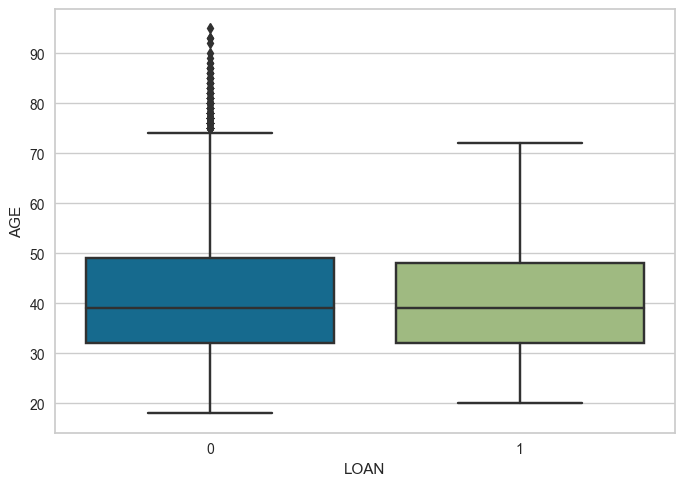

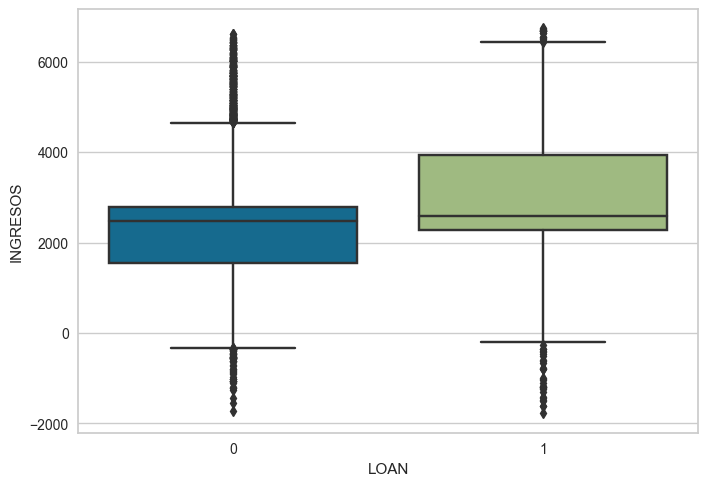

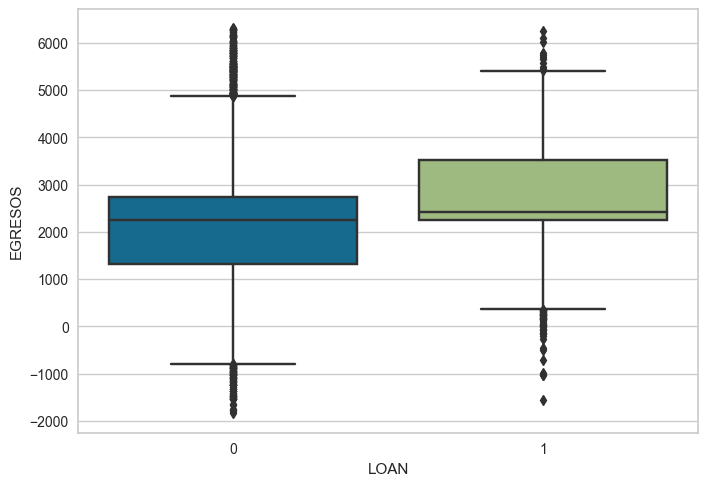

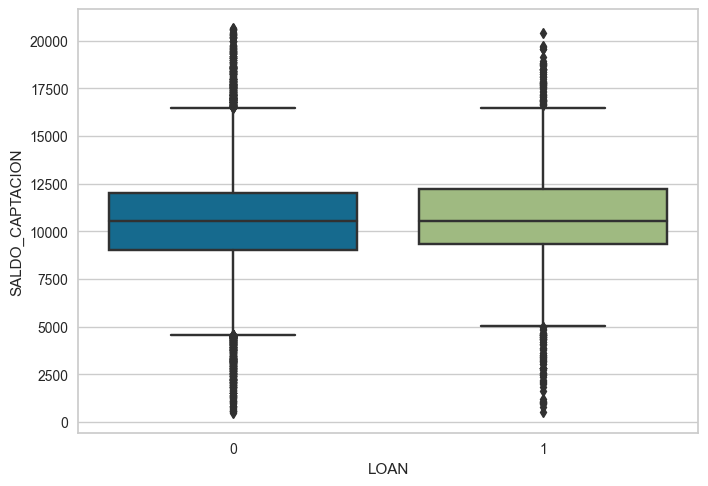

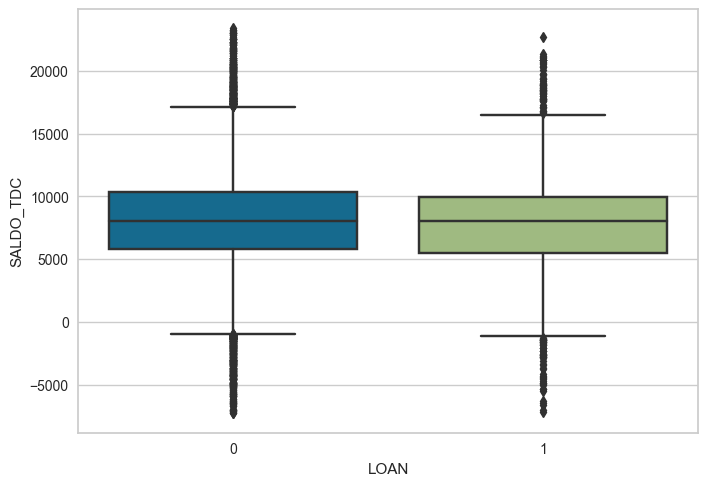

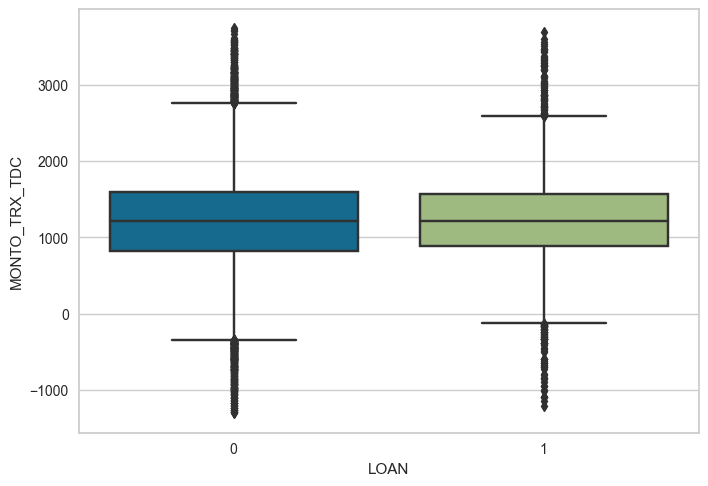

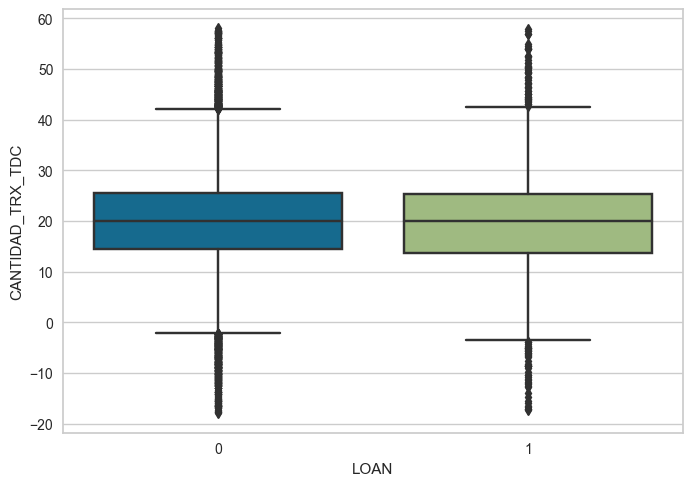

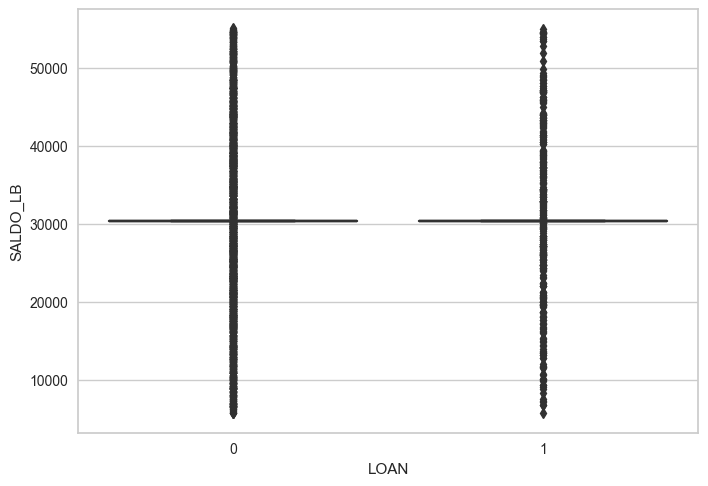

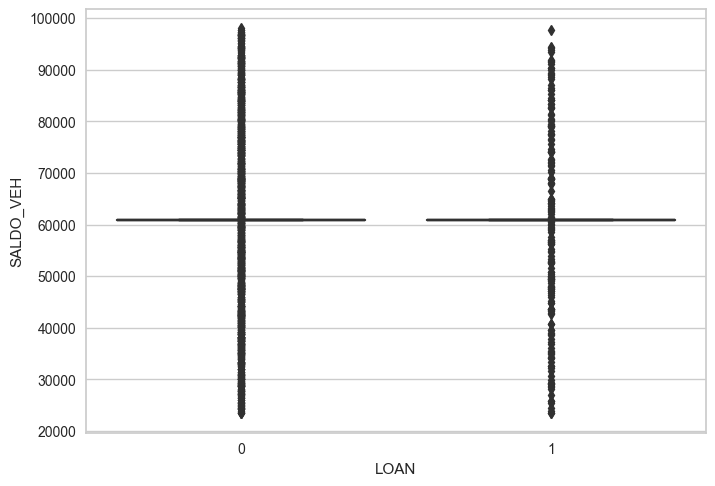

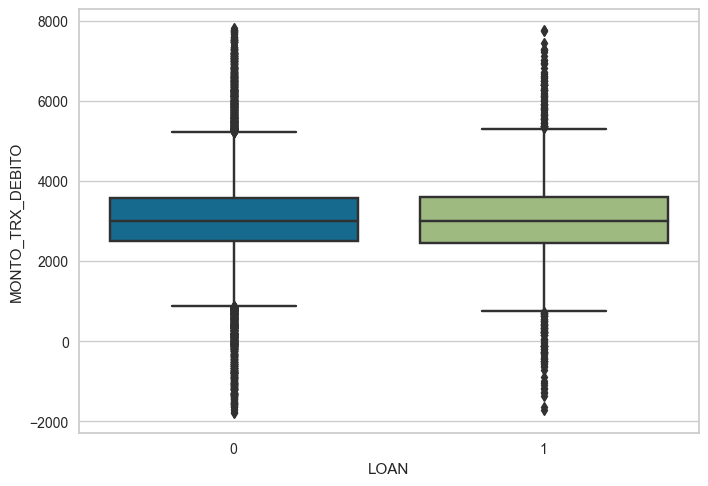

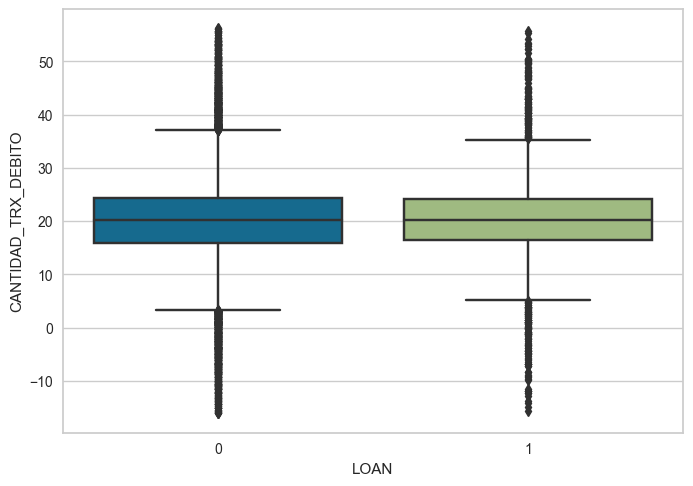

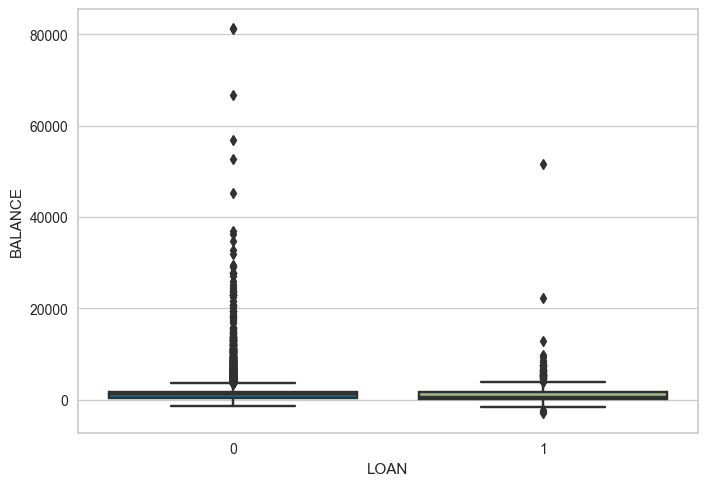

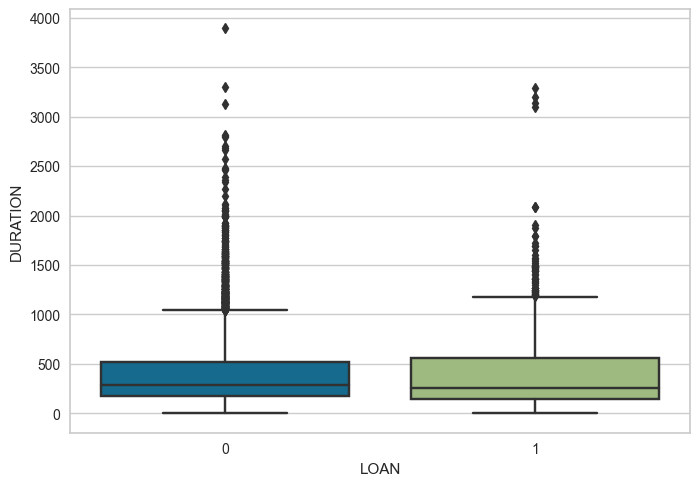

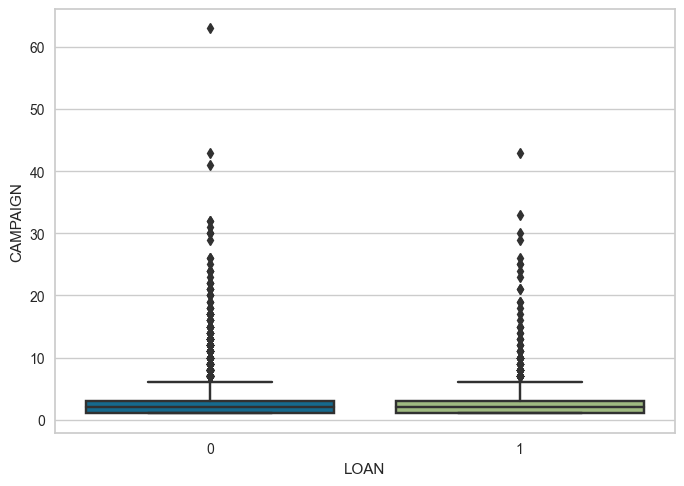

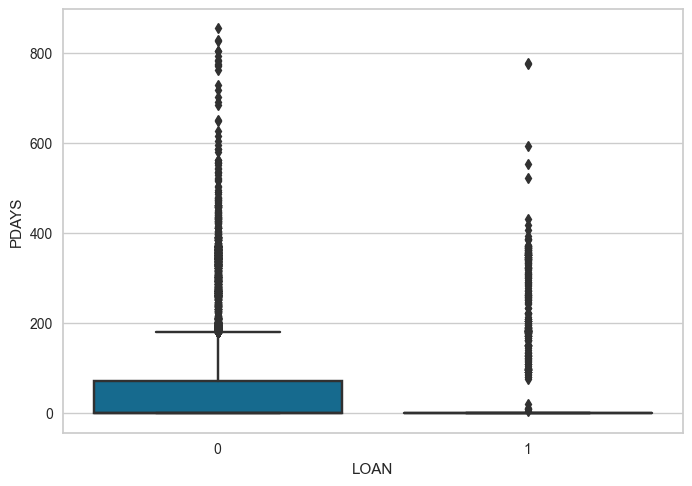

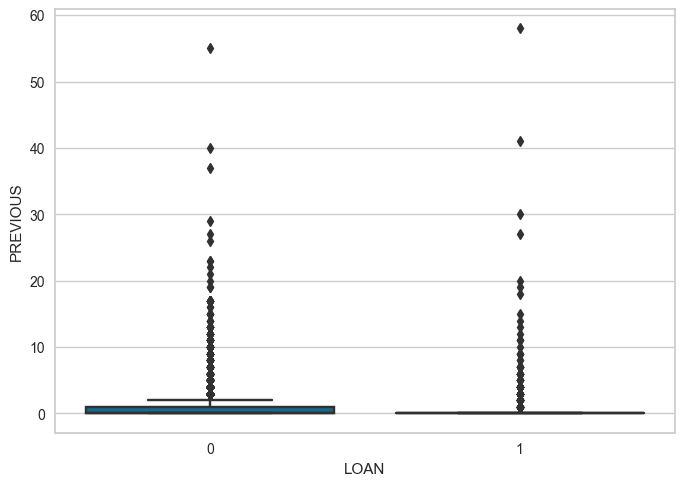

In [43]:
bivariate_analysis_numerical(df1,'LOAN',list_columns[1:])

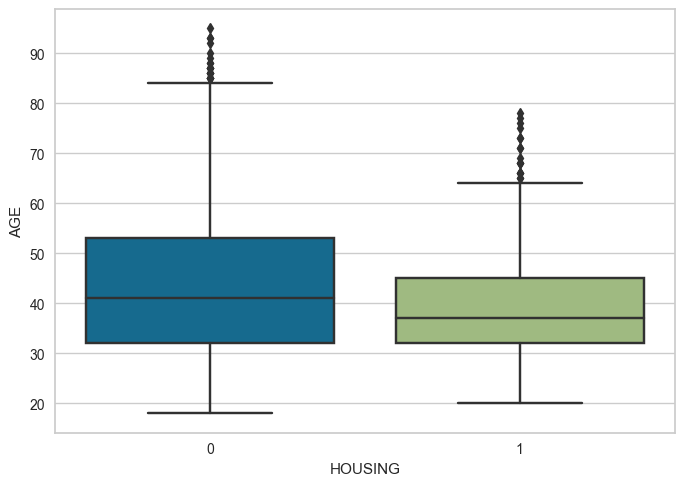

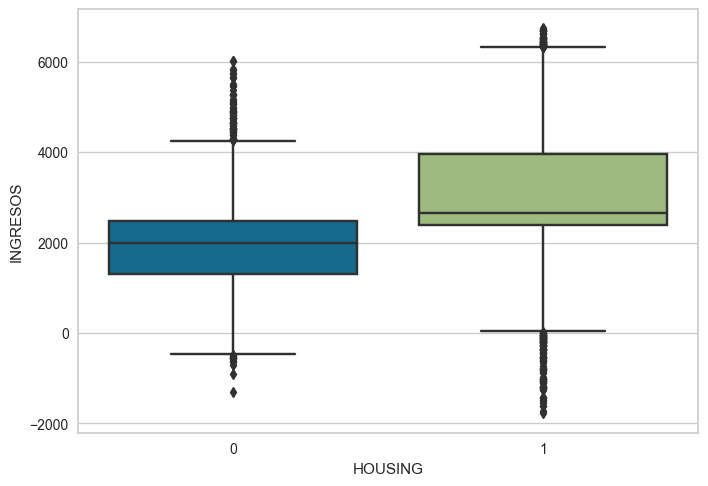

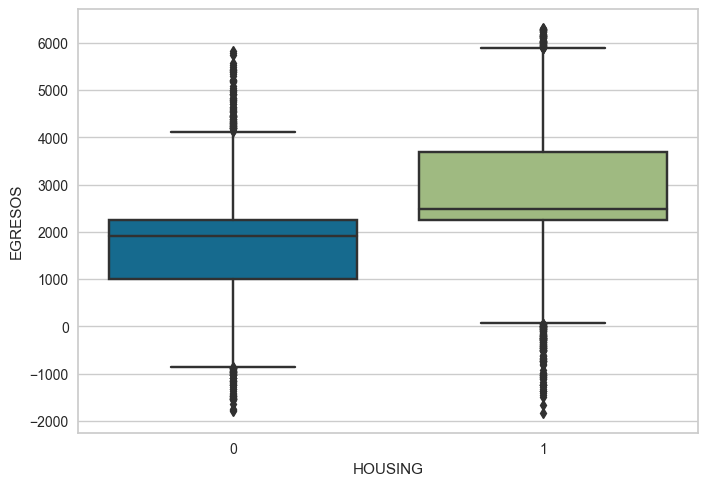

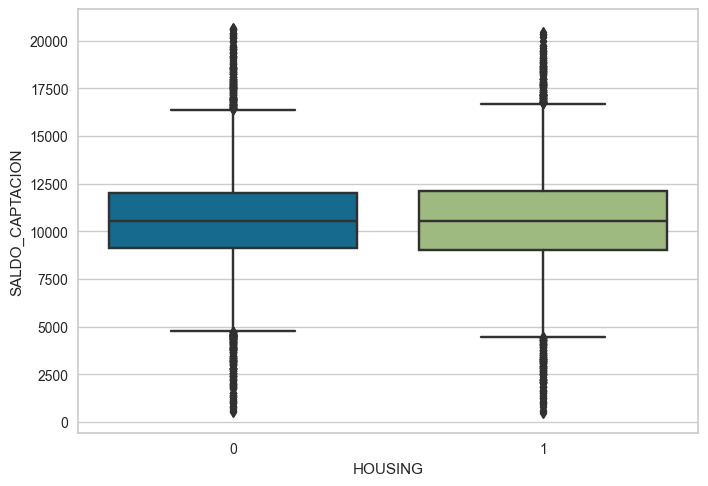

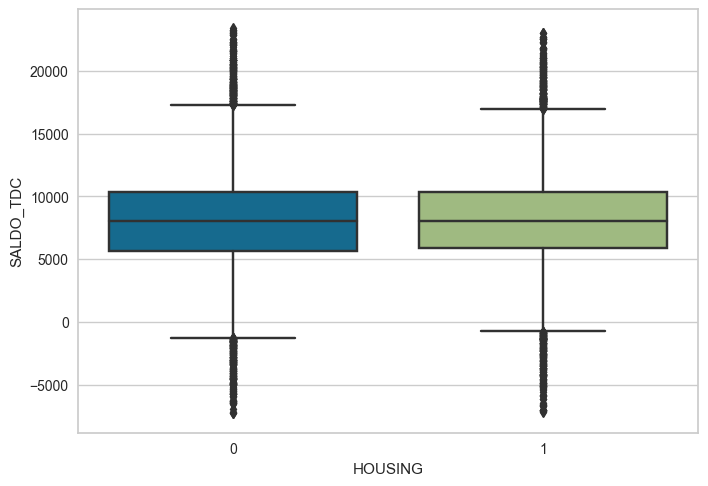

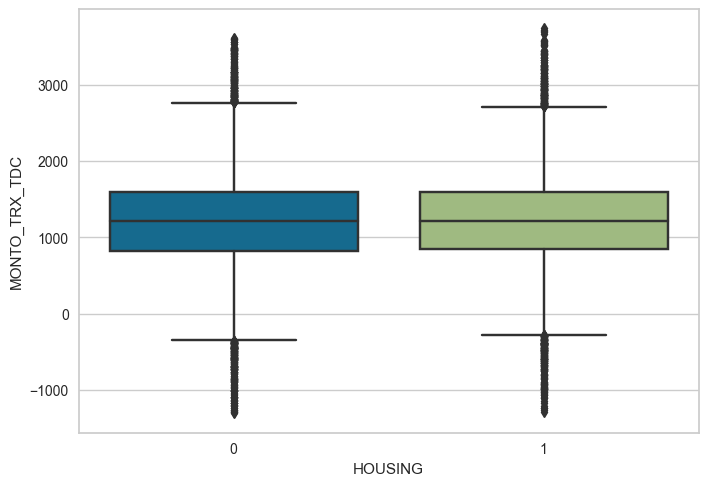

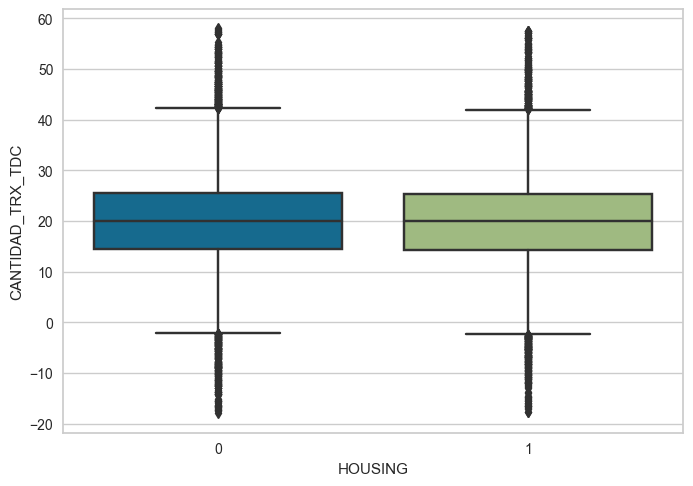

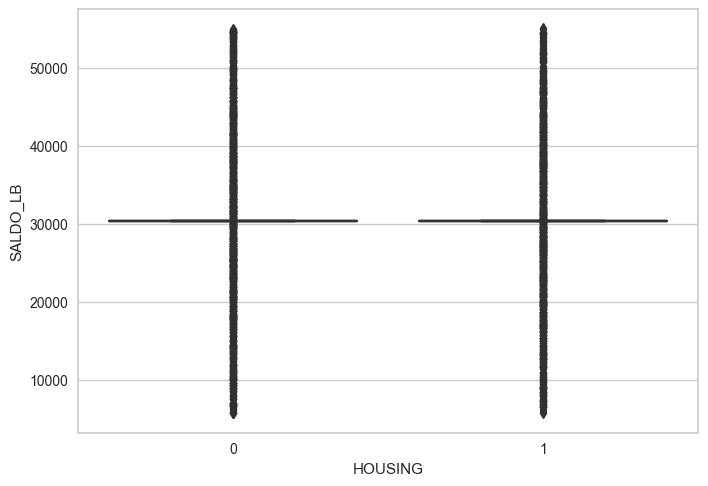

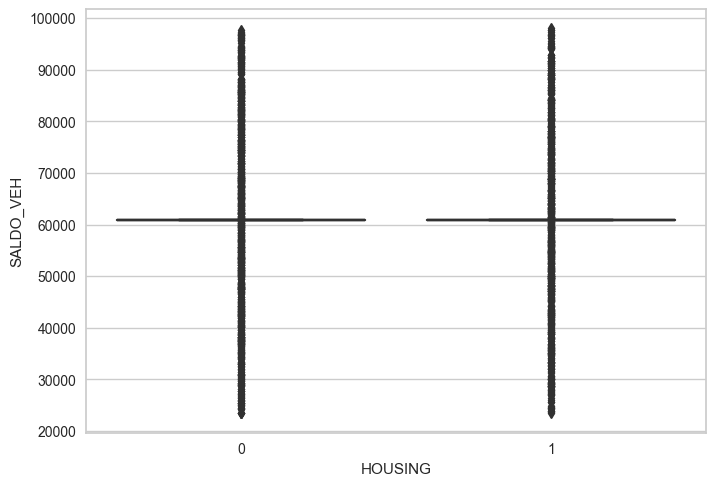

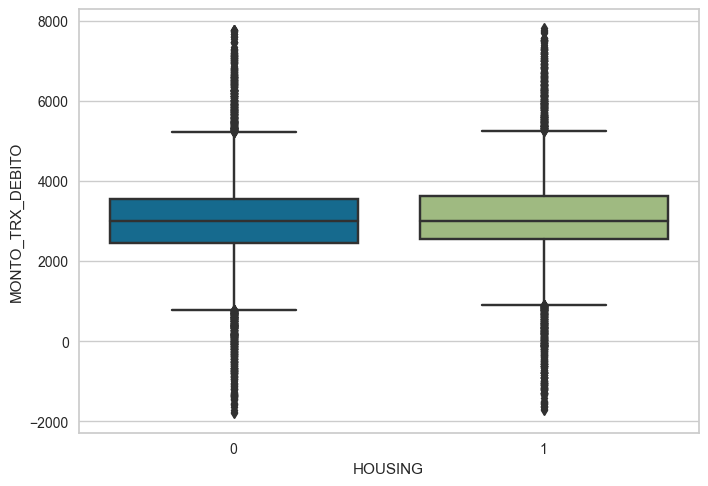

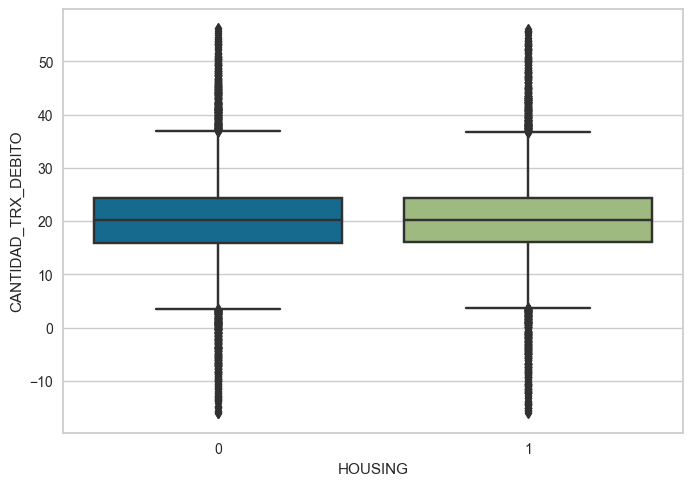

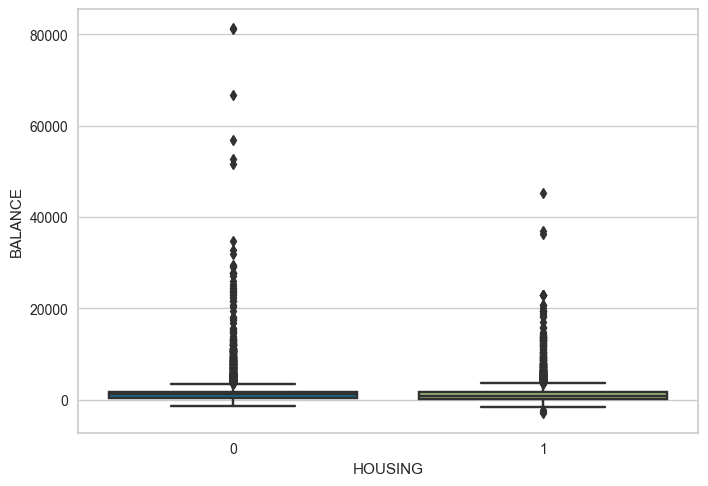

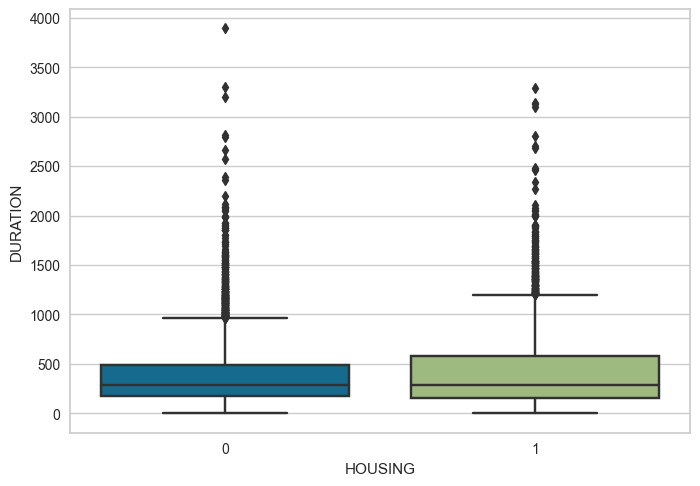

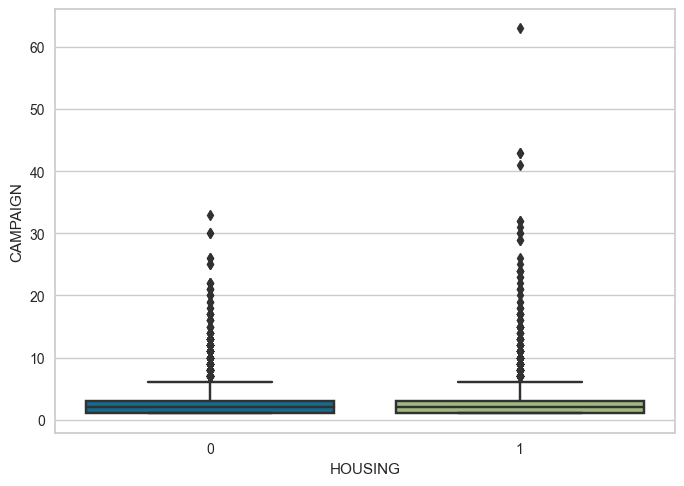

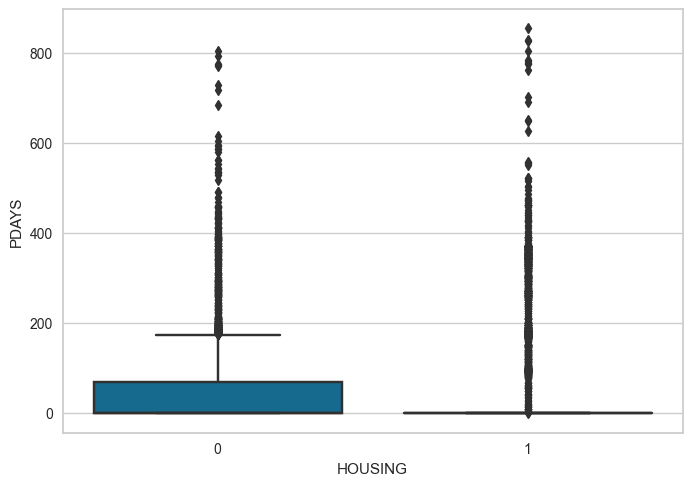

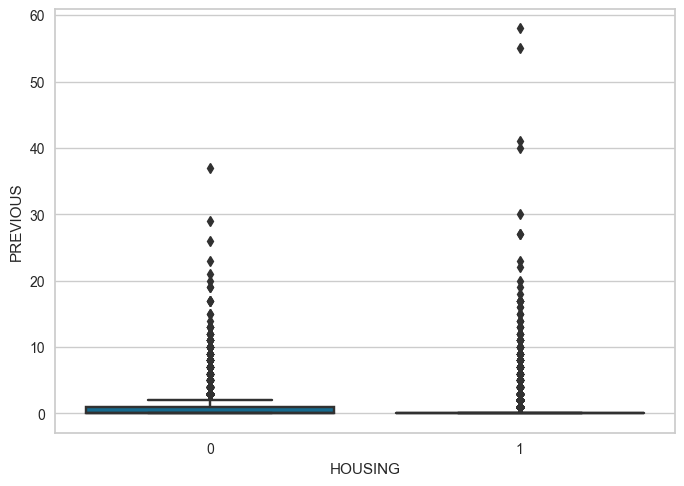

In [44]:
bivariate_analysis_numerical(df1,'HOUSING',list_columns[1:])

Descartamos las variables SALDO_LB y SALDO_VEH porque tienen una desviacion estandar muy alta, lo que indica que los datos estan muy dispersos.

Descartamos las variables DURATION, CAMPAIGN, PDAYS, PREVIOUS de acuerdo a la Hipotesis 1.

In [45]:
exp = ClassificationExperiment()

exp.setup(data=df1,
        target = 'LOAN',
        session_id = 123,
        ignore_features=['ID','HOUSING', 'BALANCE', 'DURATION', 'CAMPAIGN', 'PDAYS', 'PREVIOUS','SALDO_LB', 'SALDO_VEH'],
        train_size = 0.7,
        fix_imbalance=True,
        remove_outliers=True, 
        categorical_features=var_categoricas[:-2])

In [46]:
exp.compare_models()


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=123, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [47]:
model_LOAN=exp.create_model('catboost')

In [ ]:
# tunned_model_LOAN = exp.tune_model(model_LOAN,, search_library='scikit-learn', search_algorithm='grid')

# Graficas

-------------------------------------------------------
Generando imagen:  pr


-------------------------------------------------------
Generando imagen:  confusion_matrix


-------------------------------------------------------
Generando imagen:  error


-------------------------------------------------------
Generando imagen:  class_report


-------------------------------------------------------
Generando imagen:  boundary


-------------------------------------------------------
Generando imagen:  learning


-------------------------------------------------------
Generando imagen:  manifold


-------------------------------------------------------
Generando imagen:  calibration


-------------------------------------------------------
Generando imagen:  vc


KeyboardInterrupt: 

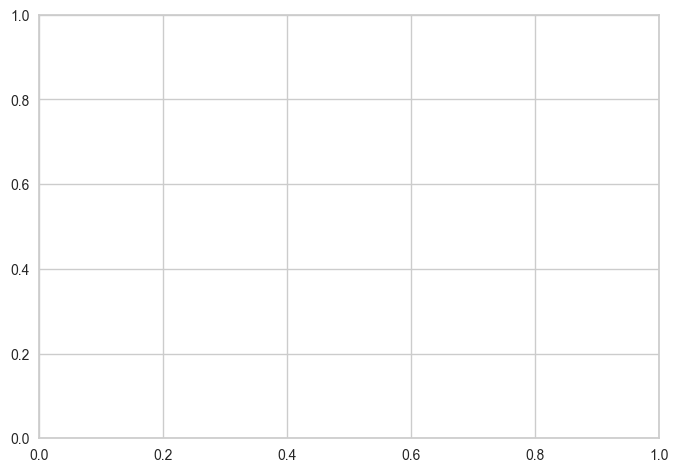

In [49]:
graficas=['pr','confusion_matrix','error','class_report','boundary','learning','manifold','calibration','vc','dimension','feature','lift','gain']

for image in graficas:
    print('-------------------------------------------------------')
    print('Generando imagen: ',image)
    exp.plot_model(model_LOAN, plot=image,save=True)

In [ ]:
exp.save_model(model_LOAN, 'my_best_pipeline_LOAN')

In [ ]:
exp1 = ClassificationExperiment()
exp1.setup(data=df1,
        target = 'HOUSING',
        session_id = 123,
        ignore_features=['ID','LOAN', 'BALANCE', 'DURATION', 'CAMPAIGN', 'PDAYS', 'PREVIOUS','SALDO_LB', 'SALDO_VEH'],
        train_size = 0.7,
        fix_imbalance=True,
        remove_outliers=True, 
        categorical_features=var_categoricas[:-2])

In [ ]:
exp1.compare_models()

In [ ]:
model_HOUSING=exp1.create_model('lightgbm')

In [ ]:
graficas=['pr','confusion_matrix','error','class_report','boundary','learning','manifold','calibration','vc','dimension','feature','lift','gain']

for image in graficas:
    print('-------------------------------------------------------')
    print('Generando imagen: ',image)
    exp1.plot_model(model_HOUSING, plot=image,save=current_path.joinpath('HOUSING'))

In [ ]:
exp1.save_model(model_HOUSING, 'my_best_pipeline_HOUSING')

In [ ]:
blend_models = exp.blend_models(estimator_list = [model_LOAN, model_HOUSING])